# Recommender Systems for Evanston's Restaurants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from collections import Counter
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
import torch
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

## EDA
### 1. Import and examine the data. Are there missing values? Do you care?

In [2]:
# Load the data from the Excel file
df_restaurants = pd.read_excel('RestaurantReviews.xlsx', sheet_name='Restaurants')
df_reviews = pd.read_excel('RestaurantReviews.xlsx', sheet_name='Reviews')

# Check for missing values
print(df_restaurants.isnull().sum())# Count missing values in each column of the Restaurants sheet
print()
print(df_reviews.isnull().sum())  # Count missing values in each column of the Reviews sheet

Restaurant Name      0
Cuisine              0
Latitude             0
Longitude            0
Average Cost         0
Open After 8pm?      0
Brief Description    0
dtype: int64

Reviewer Name                     0
Restaurant Name                   0
Rating                            0
Review Text                     550
Date of Review                    0
Birth Year                        2
Marital Status                   35
Has Children?                    38
Vegetarian?                    1350
Weight (lb)                      97
Height (in)                      54
Average Amount Spent              2
Preferred Mode of Transport       7
Northwestern Student?             1
dtype: int64


In [3]:
# df_restaurants.to_csv("./Restaurant.csv")
# df_reviews.to_csv("./Reviews.csv")

In [4]:
df_reviews.head()

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
0,Connie Neal,Lao Sze Chuan,1,Really disappointed for the dishes…. Not athle...,2022-08-10 00:00:00,1942.0,Single,No,NaN,234.0,161.0,Medium,Car Owner,No
1,Jacquelyn Rigatti,Barn Steakhouse,5,Excellent meal in a warm atmosphere! The space...,2022-11-22 00:00:00,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
2,Jacquelyn Rigatti,Brothers K Coffeehouse,4,NaN,2022-08-18 00:00:00,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
3,Jacquelyn Rigatti,Clarkes Off Campus,5,Best burger in Evanston,2022-10-30 00:00:00,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
4,Jacquelyn Rigatti,Edzo's Burger Shop,5,Second best burger in Evanston,2022-11-28 00:00:00,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No


In [5]:
# Check the levels of each column
for col in df_reviews.columns:
    print(f"{col}: {df_reviews[col].nunique()} unique values")

Reviewer Name: 1047 unique values
Restaurant Name: 67 unique values
Rating: 5 unique values
Review Text: 872 unique values
Date of Review: 432 unique values
Birth Year: 68 unique values
Marital Status: 4 unique values
Has Children?: 2 unique values
Vegetarian?: 2 unique values
Weight (lb): 192 unique values
Height (in): 55 unique values
Average Amount Spent: 3 unique values
Preferred Mode of Transport: 3 unique values
Northwestern Student?: 2 unique values


In [6]:
# Check the levels of each column
for col in df_restaurants.columns:
    print(f"{col}: {df_restaurants[col].nunique()} unique values")

Restaurant Name: 63 unique values
Cuisine: 24 unique values
Latitude: 63 unique values
Longitude: 63 unique values
Average Cost: 5 unique values
Open After 8pm?: 2 unique values
Brief Description: 63 unique values


In [7]:
missing_col = df_reviews.columns[df_reviews.isnull().any()]
print("The missing columns for reviews are: "+", ".join(missing_col))

The missing columns for reviews are: Review Text, Birth Year, Marital Status, Has Children?, Vegetarian?, Weight (lb), Height (in), Average Amount Spent, Preferred Mode of Transport, Northwestern Student?


#### 1) `Review Text`

In [8]:
missing_review_text = df_reviews['Review Text'].isnull().sum()
total_rows = df_reviews.shape[0]
missing_proportion = (missing_review_text / total_rows) * 100
print(f"Missing proportion of Review Text: {missing_proportion:.2f}%")

Missing proportion of Review Text: 38.09%


The missing proportion of 'Review Text' is about 38.09%. Since this is a considerable proportion, dropping the missing values could result in losing a significant amount of data. So, let's fill in the missing values instead.

In [9]:
# fill with an empty string ""
df_reviews['Review Text'].fillna('', inplace=True)
# check missing
df_reviews['Review Text'].isnull().sum()

0

#### 2) numerical variables `Birth Year`, `Weight (lb)`, `Height (in)`

In [10]:
mv_weight_height=df_reviews.loc[df_reviews['Weight (lb)'].isna()
                                | df_reviews['Height (in)'].isna(),
                                ['Reviewer Name', 'Weight (lb)', 'Height (in)']]
mv_weight_height['Reviewer Name'].value_counts()

Karissa Corley        36
Bernice Bahena        32
Jacquelyn Rigatti      9
John Cermeno           2
Anna Klein             1
Lori Knab              1
Antonio Read           1
Charles Collins        1
Mary Ellis             1
Nick Carlisle          1
Raymond Swiger         1
Theodore Tribble       1
Nancy Williams         1
Susan Copeland         1
Mary Mitchell          1
Robert Niess           1
Victoria Mosley        1
Zachary Geiger         1
Scott Stamps           1
William Nev            1
Steven Trantham        1
Jennifer Armagost      1
Christopher Thomas     1
Name: Reviewer Name, dtype: int64

In [11]:
mv_weight_height[~mv_weight_height['Weight (lb)'].isna()]

,Reviewer Name,Weight (lb),Height (in)
1302,Lori Knab,190.0,NaN


In [12]:
# mv_weight_height[~mv_weight_height['Height (in)'].isna()].shape[0] # 44
mv_weight_height[~mv_weight_height['Height (in)'].isna()].head()

,Reviewer Name,Weight (lb),Height (in)
124,Steven Trantham,NaN,167.0
447,Scott Stamps,NaN,167.0
562,Karissa Corley,NaN,158.0
563,Karissa Corley,NaN,158.0
564,Karissa Corley,NaN,158.0


Birth Year, Weight (lb), Height (in)We first got the columns of `Reviewer Name`, `Weight (lb)`, and `Height (in)` given `Weight (lb)` or `Height (in)` that are missing. Then we derived the number of missing value for each reviwers.

Also, I thought that some reviewers might only provide their wieght or only provide their height. From the result, there is only one reviewer Lori Knab who only provided the weight. And there are 44 observations that only has the height. Therefore, I considered to use linear regression model approach to fill in the missing values for `Weight (lb)` or `Height (in)`.

In [13]:
# Split the data into two subsets: one with missing values and one with non-missing values
miss = df_reviews['Weight (lb)'].isna() | df_reviews['Height (in)'].isna()
df_missing = df_reviews[miss]
df_nonmissing = df_reviews[-miss]

# Fit a linear regression model to the non-missing values
Y = df_nonmissing[['Weight (lb)']]
X = df_nonmissing[['Height (in)']]

model_lm = LinearRegression().fit(X, Y)

# Use the fitted model to predict the missing values
X_missing = df_missing[['Height (in)']].dropna()
y_pred = model_lm.predict(X_missing)
# update predicted 'Weight (lb)'
df_reviews.loc[X_missing.index, 'Weight (lb)'] = y_pred

We first split the dataset into two subsets, one with missing values that either `Weight (lb)` or `Height (in)` is missing and another with non-missing values. Using the non-missing dataset to train our linear model allowed us to predict the missing values of `Weight (lb)` and `Height (in)`. For example, at first, we trained our model with x = Height (in) and y = Weight (lb). Secondly, we dropped the missing values for `Height (in)` because we can not predict a null value, and this was the missing dataset that only contains `Height (in)`. Thirdly, we used this to predict the missing `Weight (lb)` in a linear model trained by the non-missing dataset. Similarly, we dropped the missing values for `Weight (lb)` and predict the missing `Height (in)`. Finally, we successfully predicted as many the missing `Height (in)` and `Weight (lb)` as possible given the information of non-missing `Height (in)` or `Weight (lb)`.

In [14]:
# Fit a linear regression model to the non-missing values
Y1 = df_nonmissing[['Height (in)']]
X1 = df_nonmissing[['Weight (lb)']]
model_lm1 = LinearRegression().fit(X1, Y1)

# Use the fitted model to preict the missing values
X_missing1 = df_missing[['Weight (lb)']].dropna()
y_pred1 = model_lm1.predict(X_missing1)
# update predicted 'Weight (lb)'
df_reviews.loc[X_missing1.index, 'Height (in)'] = y_pred1

In [15]:
# checking missing
df_reviews.isnull().sum()

Reviewer Name                     0
Restaurant Name                   0
Rating                            0
Review Text                       0
Date of Review                    0
Birth Year                        2
Marital Status                   35
Has Children?                    38
Vegetarian?                    1350
Weight (lb)                      53
Height (in)                      53
Average Amount Spent              2
Preferred Mode of Transport       7
Northwestern Student?             1
dtype: int64

Now, we have imputed all the possible weight and height by using linear regression models. The 53 left missing values for both variables would be then replaced by the median. Also, there are only 2 missing values for birth year, we would replace it by the median.

In [16]:
## replace by median
df_reviews['Birth Year'].fillna(df_reviews['Birth Year'].median(), inplace=True)
df_reviews['Weight (lb)'].fillna(df_reviews['Weight (lb)'].median(), inplace=True)
df_reviews['Height (in)'].fillna(df_reviews['Height (in)'].median(), inplace=True)

# check missing
df_reviews[['Birth Year', 'Weight (lb)', 'Height (in)']].isnull().sum()

Birth Year     0
Weight (lb)    0
Height (in)    0
dtype: int64

#### 3) categorical variables: `Average Amount Spent`, `Marital Status`, `Has Children?`, `Vegetarian?`, `Preferred Mode of Transport`, and `Northwestern Student?`.

Since there are only one 2 missing values for `Average Amount Spent`, 7 for `Preferred Mode of Transport`, and 1 for `Northwestern Student?  `, we can use a simple method, replacing by the mode of their columns.

In [17]:
df_reviews['Average Amount Spent'].fillna(df_reviews['Average Amount Spent'].mode()[0], inplace=True)
df_reviews['Preferred Mode of Transport'].fillna(df_reviews['Preferred Mode of Transport'].mode()[0], inplace=True)
df_reviews['Northwestern Student?'].fillna(df_reviews['Northwestern Student?'].mode()[0], inplace=True)
df_reviews[['Average Amount Spent', 'Preferred Mode of Transport', 'Northwestern Student?']].isnull().sum()

Average Amount Spent           0
Preferred Mode of Transport    0
Northwestern Student?          0
dtype: int64

In [18]:
col_mis1=['Average Amount Spent', 'Preferred Mode of Transport', 'Northwestern Student?']
for col in col_mis1:
    print(f"{col}: has levels of {df_reviews[col].unique()}")

Average Amount Spent: has levels of ['Medium' 'Low' 'High']
Preferred Mode of Transport: has levels of ['Car Owner' 'On Foot' 'Public Transit']
Northwestern Student?: has levels of ['No' 'Yes']


#### 3.1） For `Marital Status`, `Has Children?`, `Vegetarian?`

In [19]:
col_mis2=['Marital Status', 'Has Children?', 'Vegetarian?']
for col in col_mis2:
    print(f"{col}: has levels of {df_reviews[col].unique()}")

Marital Status: has levels of ['Single' 'Married' 'Widow' nan 'SIngle']
Has Children?: has levels of ['No' 'Yes' nan]
Vegetarian?: has levels of [nan 'No' 'Yes']


We see that there should be 3 levels in `Marital Status`, 'Single', 'Married', and 'Widow'. Therefore, we should change 'SIngle' to 'Single' because they are the same category. For `Has Children?` and `Vegetarian?`, they are binary variables (Yes/No).

In [20]:
# change 'SIngle' to 'single'
df_reviews['Marital Status'] = df_reviews['Marital Status'].replace("SIngle", "Single")
df_reviews['Marital Status'].unique()

array(['Single', 'Married', 'Widow', nan], dtype=object)

In [21]:
# checking missing proportions
df_reviews[col_mis2].isnull().sum()/df_reviews.shape[0]*100

Marital Status     2.423823
Has Children?      2.631579
Vegetarian?       93.490305
dtype: float64

For `Vegetarian?`, since the porportion is 93.490305% that there are many missing vlaues, we created a new category 'unknown'.

In [22]:
miss_vege = df_reviews['Vegetarian?'].isnull()
df_reviews.loc[miss_vege, 'Vegetarian?'] = 'unknown'
df_reviews['Vegetarian?'].value_counts()

unknown    1350
No           65
Yes          29
Name: Vegetarian?, dtype: int64

In [23]:
df_reviews.isnull().sum()

Reviewer Name                   0
Restaurant Name                 0
Rating                          0
Review Text                     0
Date of Review                  0
Birth Year                      0
Marital Status                 35
Has Children?                  38
Vegetarian?                     0
Weight (lb)                     0
Height (in)                     0
Average Amount Spent            0
Preferred Mode of Transport     0
Northwestern Student?           0
dtype: int64

We also created a new category 'unknown' for the missing values of `Has Children?` and `Has Children?`

In [24]:
df_reviews[df_reviews['Has Children?'].isnull()]['Reviewer Name'].value_counts()

Bernice Bahena     32
Steven Trantham     1
Madeline Lefler     1
Mark Wilson         1
Edwin Anderson      1
Judith Cruz         1
Annie Boney         1
Name: Reviewer Name, dtype: int64

In [25]:
df_reviews[df_reviews['Marital Status'].isnull()]['Reviewer Name'].value_counts()

Bernice Bahena    32
William Nev        1
Mark Wilson        1
Raymond Swiger     1
Name: Reviewer Name, dtype: int64

In [26]:
df_reviews['Marital Status'] = df_reviews['Marital Status'].fillna('unknown')

df_reviews['Has Children?'] = df_reviews['Has Children?'].fillna('unknown')


In [27]:
# df_reviews['Marital Status'] = df_reviews['Marital Status'].fillna('unknown')
# df_reviews['Has Children?'] = df_reviews['Has Children?'].fillna('unknown')

# check missing
df_reviews.isnull().sum()

Reviewer Name                  0
Restaurant Name                0
Rating                         0
Review Text                    0
Date of Review                 0
Birth Year                     0
Marital Status                 0
Has Children?                  0
Vegetarian?                    0
Weight (lb)                    0
Height (in)                    0
Average Amount Spent           0
Preferred Mode of Transport    0
Northwestern Student?          0
dtype: int64

In [28]:
print(df_reviews['Marital Status'].unique())
print(df_reviews['Has Children?'].unique())
print(df_reviews['Average Amount Spent'].unique())
print(df_reviews['Preferred Mode of Transport'].unique())
print(df_reviews['Northwestern Student?'].unique())

['Single' 'Married' 'Widow' 'unknown']
['No' 'Yes' 'unknown']
['Medium' 'Low' 'High']
['Car Owner' 'On Foot' 'Public Transit']
['No' 'Yes']


### 2.Make some histograms to try and better understand the data distribution. For example, you might consider making histograms for 'has children', 'vegetarian', 'weight', 'prefered mode of transport', 'average amount spent', and 'Northwestern student'. Also consider making histograms for the 'cusine' in Restaurants.csv. Is the dataset properly balanced?

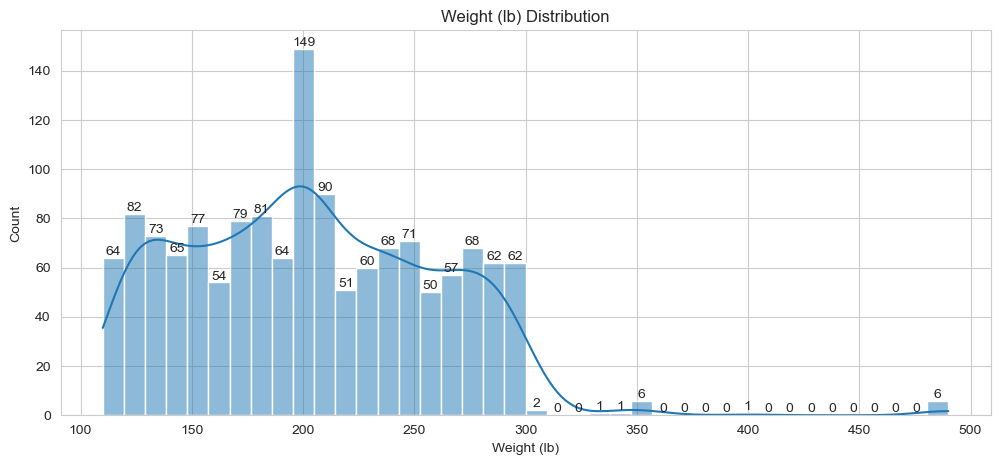

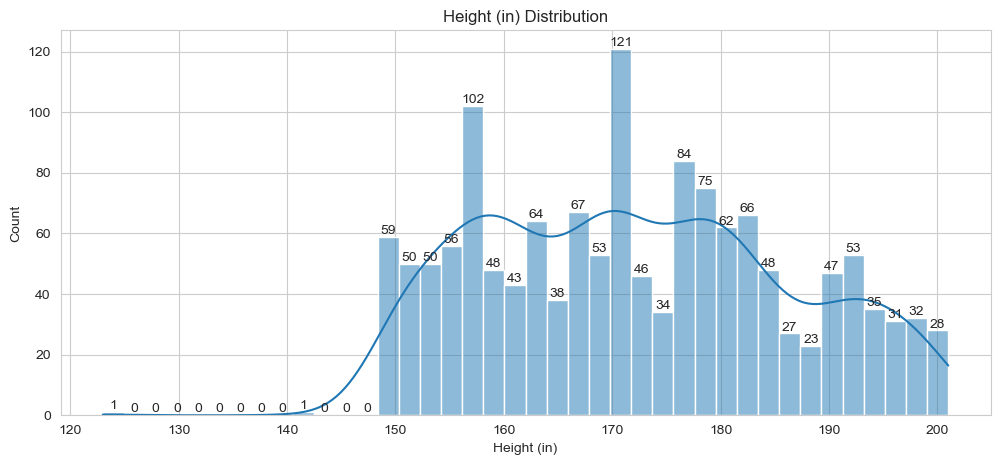

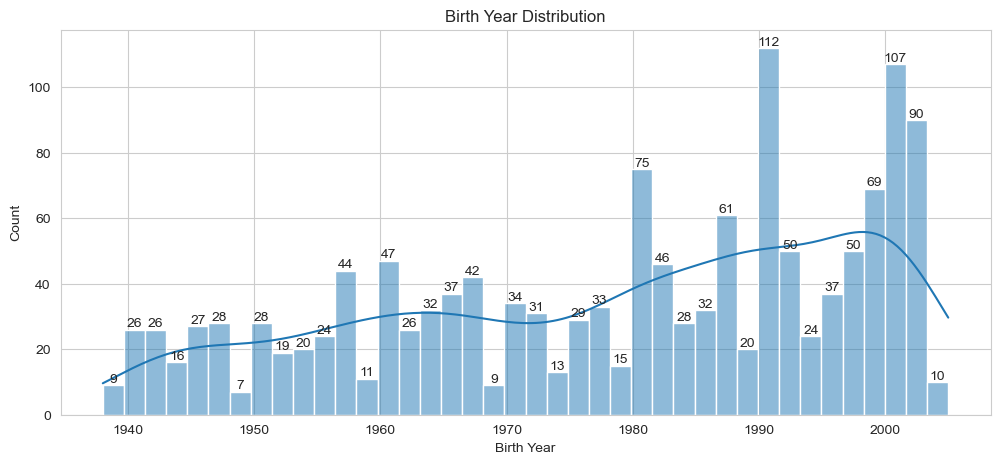

In [29]:
# Weight (lb)
plt.figure(figsize=(12, 5))
ax=sns.histplot(data=df_reviews, x='Weight (lb)', bins=40, kde=True)
plt.title('Weight (lb) Distribution')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

# Height (in)
plt.figure(figsize=(12, 5))
ax=sns.histplot(data=df_reviews, x='Height (in)', bins=40, kde=True)
plt.title('Height (in) Distribution')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

# Birth Year
plt.figure(figsize=(12, 5))
ax=sns.histplot(data=df_reviews, x='Birth Year', bins=40, kde=True)
plt.title('Birth Year Distribution')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()


In [30]:
df_reviews['Weight (lb)'].sort_values(ascending=False)

802     490.0
801     490.0
804     490.0
803     490.0
800     490.0
        ...  
1438    114.0
657     114.0
649     114.0
1435    114.0
279     110.0
Name: Weight (lb), Length: 1444, dtype: float64

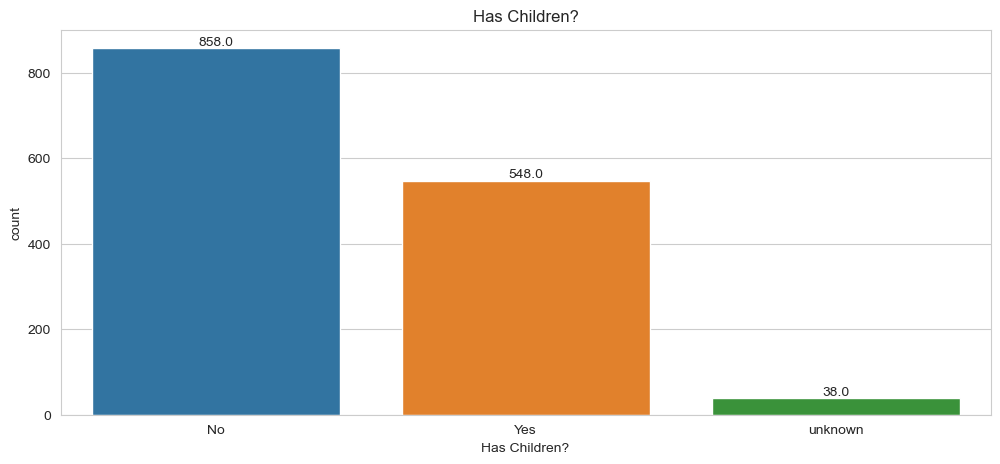

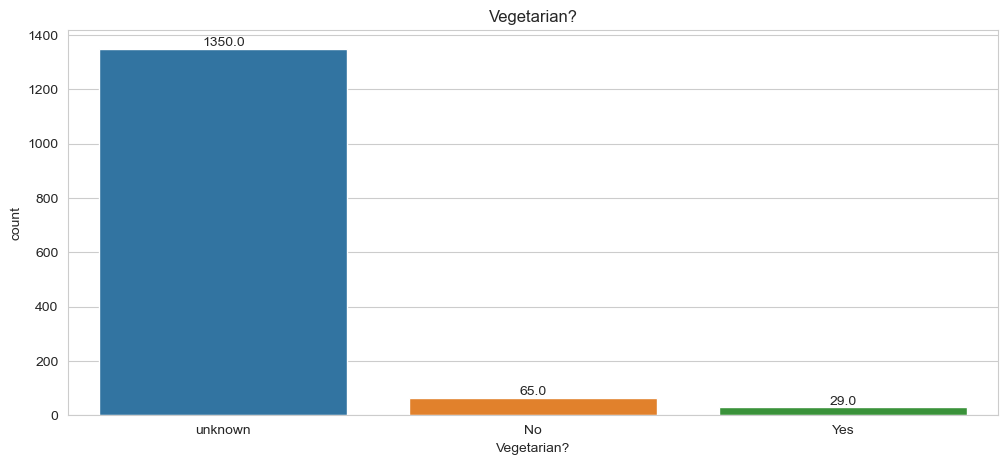

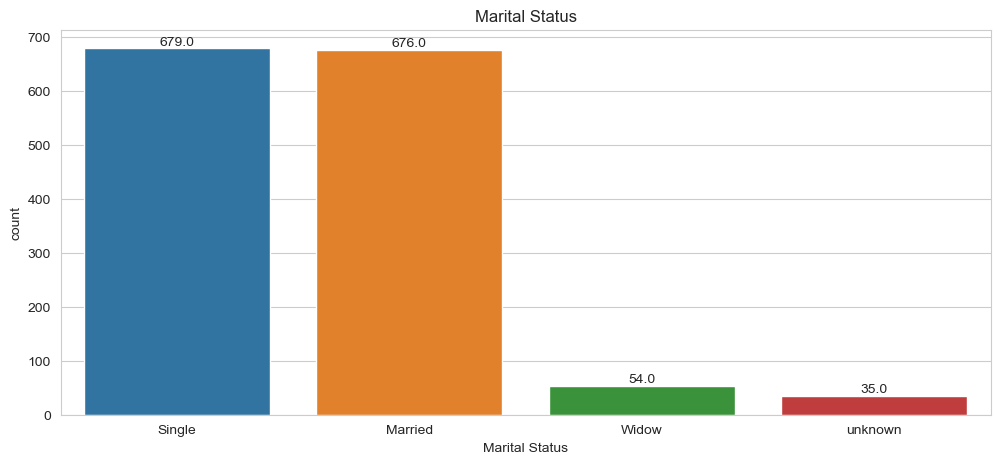

In [31]:
# Has Children?
plt.figure(figsize=(12, 5))
ax=sns.countplot(x='Has Children?', data=df_reviews)
plt.title('Has Children?')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

# Vegetarian?
plt.figure(figsize=(12, 5))
ax=sns.countplot(x='Vegetarian?', data=df_reviews)
plt.title('Vegetarian?')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

# Marital Status
plt.figure(figsize=(12, 5))
ax=sns.countplot(x='Marital Status', data=df_reviews)
plt.title('Marital Status')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

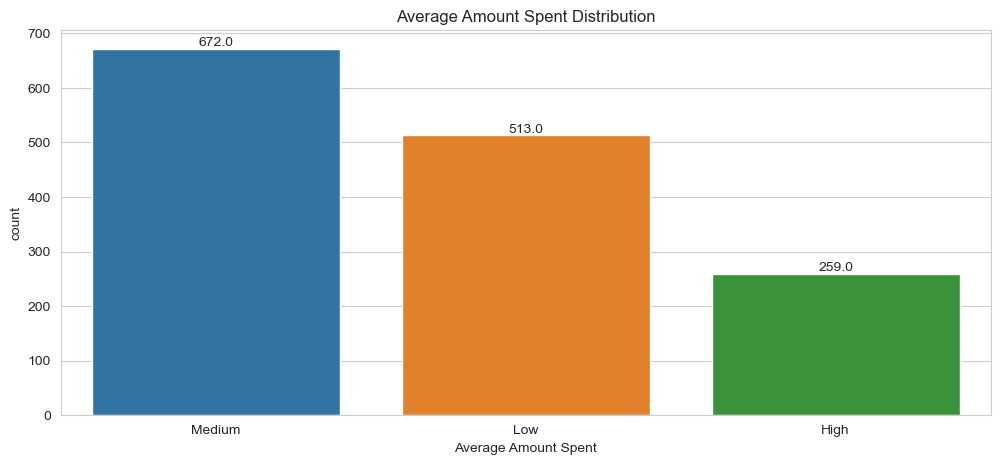

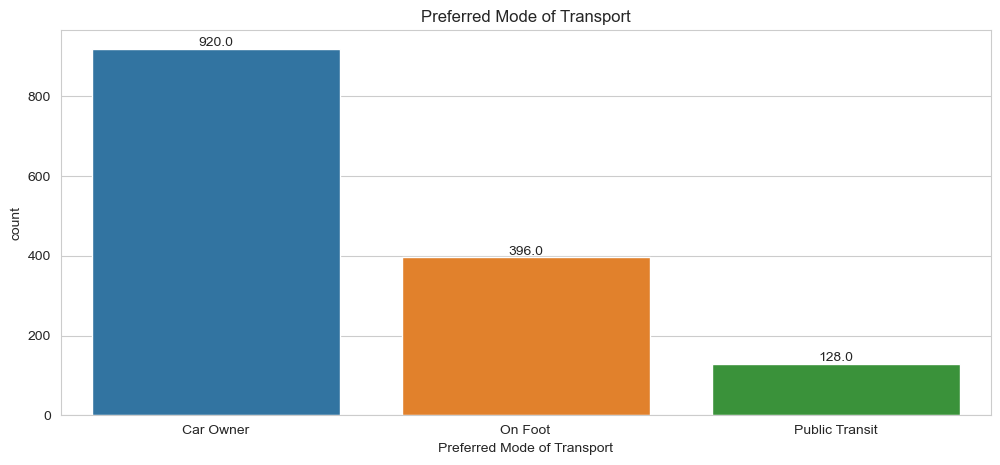

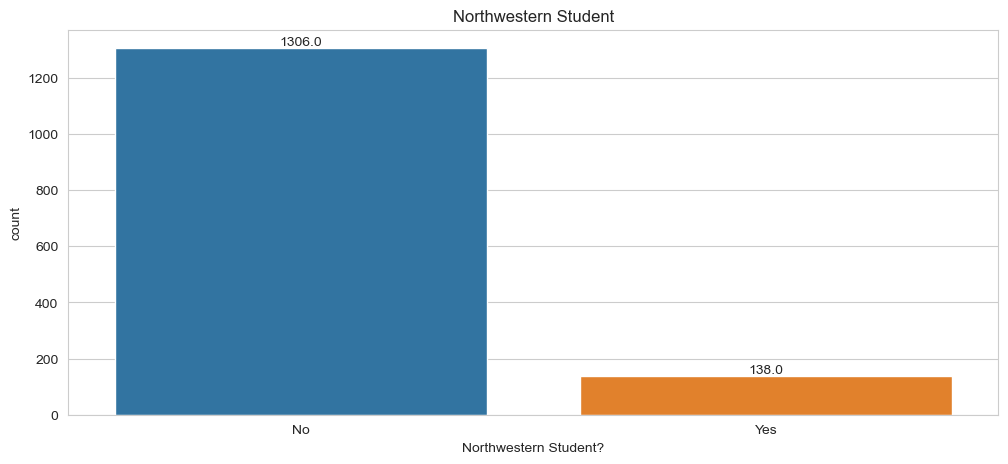

In [32]:
# Average Amount Spent
plt.figure(figsize=(12, 5))
ax=sns.countplot(data=df_reviews, x='Average Amount Spent')
plt.title('Average Amount Spent Distribution')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

# Preferred Mode of Transport
plt.figure(figsize=(12, 5))
ax=sns.countplot(x='Preferred Mode of Transport', data=df_reviews)
plt.title('Preferred Mode of Transport')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

# Northwestern Student?
plt.figure(figsize=(12, 5))
ax=sns.countplot(x='Northwestern Student?', data=df_reviews)
plt.title('Northwestern Student')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

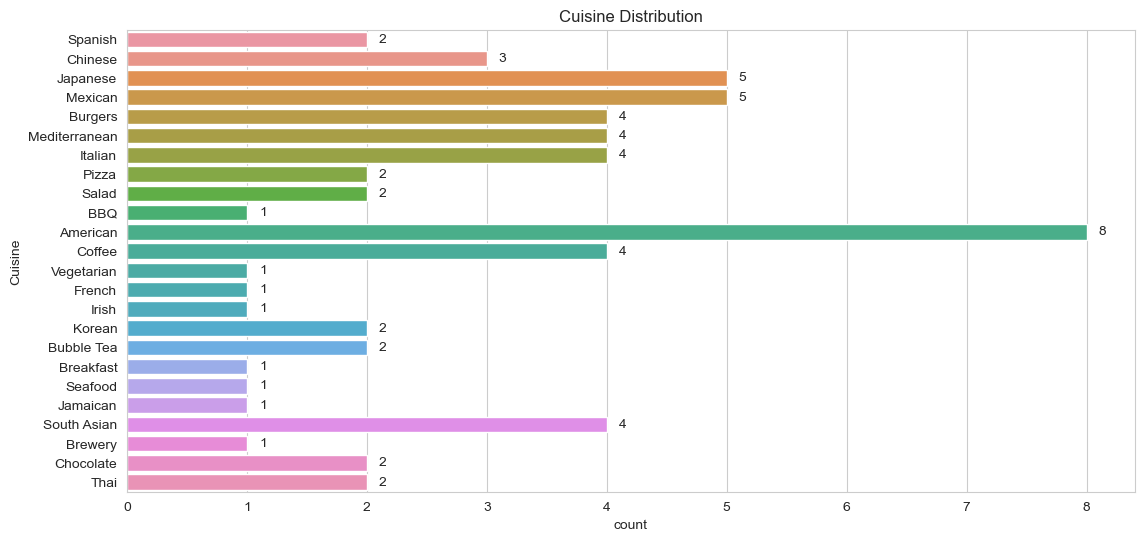

In [33]:
# for  'Cuisine'
plt.figure(figsize=(13, 6))
ax=sns.countplot(y='Cuisine', data=df_restaurants)
plt.title('Cuisine Distribution')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{int(width)}', (x + width + 0.1, y + height/2), ha='left', va='center')
plt.show()

In [34]:
df_reviews["Northwestern Student?"].value_counts()/df_reviews.shape[0]*100

No     90.443213
Yes     9.556787
Name: Northwestern Student?, dtype: float64

In [35]:
df_reviews["Vegetarian?"].value_counts()/df_reviews.shape[0]*100

unknown    93.490305
No          4.501385
Yes         2.008310
Name: Vegetarian?, dtype: float64

From the plots for categorical variables, we were interested in `Vegetarian?` and `Northwestern Student?` based on some certain problmes we want to solve because there are unbalance problems. For instance, there are 90.23% of "No" in `Northwestern Student?` and 93.34% of "unknown" in `Vegetarian?`.

### 3. Perform clustering on the user demographic data, using a clustering algorithm of your choice. You will need to transform the categorical variables into one-hot encodings. Are there any obvious clusters of users?

In [36]:
df_reviews.columns

Index(['Reviewer Name', 'Restaurant Name', 'Rating', 'Review Text',
       'Date of Review', 'Birth Year', 'Marital Status', 'Has Children?',
       'Vegetarian?', 'Weight (lb)', 'Height (in)', 'Average Amount Spent',
       'Preferred Mode of Transport', 'Northwestern Student?'],
      dtype='object')

In [37]:
# 1. Select demographic columns
demographic_columns = ['Birth Year', 'Weight (lb)', 'Height (in)', 
                       'Marital Status', 'Has Children?',
                       'Vegetarian?', 'Average Amount Spent',
                       'Preferred Mode of Transport', 'Northwestern Student?']
df_demographics = df_reviews[demographic_columns]

In [38]:
df_demographics.head()

,Birth Year,Weight (lb),Height (in),Marital Status,Has Children?,Vegetarian?,Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
0,1942.0,234.0,161.0,Single,No,unknown,Medium,Car Owner,No
1,1998.0,200.0,171.0,Single,No,unknown,Medium,On Foot,No
2,1998.0,200.0,171.0,Single,No,unknown,Medium,On Foot,No
3,1998.0,200.0,171.0,Single,No,unknown,Medium,On Foot,No
4,1998.0,200.0,171.0,Single,No,unknown,Medium,On Foot,No


In [39]:
df_demographics.shape

(1444, 9)

In [40]:
# 2) Convert categorical variables into one-hot encodings:
## we don't need to convert the binary variables  
df_demographics_encoded = pd.get_dummies(df_demographics,
                                         columns=['Marital Status', 'Has Children?',
                                                  'Vegetarian?', 'Average Amount Spent',
                                                 'Preferred Mode of Transport'])

df_demographics_encoded['Northwestern Student?'] = df_demographics_encoded['Northwestern Student?'].replace(['Yes', 'No'], [1, 0])

# 3) Scale the numerical variables of the data:
numerical_columns = ['Birth Year', 'Weight (lb)', 'Height (in)']

scaler = StandardScaler()
df_demographics_encoded[numerical_columns] = scaler.fit_transform(df_demographics_encoded[numerical_columns])

We did not transform binary variables to one-hot encoding when using k-means clustering. Binary variables only have two possible values, typically 0 and 1, and they can be used directly in k-means without the need for one-hot encoding. In fact, converting binary variables to one-hot encoding can increase the dimensionality of the data, which can be computationally expensive and may not improve the clustering performance.

Therefore, we transformed the categorical variables `Marital Status`, `Has Children?`, `Vegetarian?`, `Average Amount Spent`, and `Preferred Mode of Transport` to one-hot encoding. And transform `Northwestern Student?` to binary variables 0 and 1. And we Also scale the numercial variables, `Birth Year`, `Weight (lb)`, and `Height (in)` by standardizing 

In [41]:
df_demographics_encoded

,Birth Year,Weight (lb),Height (in),Northwestern Student?,Marital Status_Married,Marital Status_Single,Marital Status_Widow,Marital Status_unknown,Has Children?_No,Has Children?_Yes,Has Children?_unknown,Vegetarian?_No,Vegetarian?_Yes,Vegetarian?_unknown,Average Amount Spent_High,Average Amount Spent_Low,Average Amount Spent_Medium,Preferred Mode of Transport_Car Owner,Preferred Mode of Transport_On Foot,Preferred Mode of Transport_Public Transit
0,-1.950074,0.531176,-0.793823,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0
1,1.042331,-0.065323,-0.083096,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0
2,1.042331,-0.065323,-0.083096,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0
3,1.042331,-0.065323,-0.083096,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0
4,1.042331,-0.065323,-0.083096,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,1.309510,1.583821,0.840851,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0
1440,-0.133256,0.899602,1.622651,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
1441,0.668281,0.776793,-1.078114,1,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
1442,0.882024,1.671541,0.627632,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0


In [42]:
# 4) Apply K-means clustering:
## we are using the Elbow method to determine the optimal K
### codes are from page 58 in lecture 3 Clustering notes

From pages 59 in Lecture 3 clustering (Elbow method)

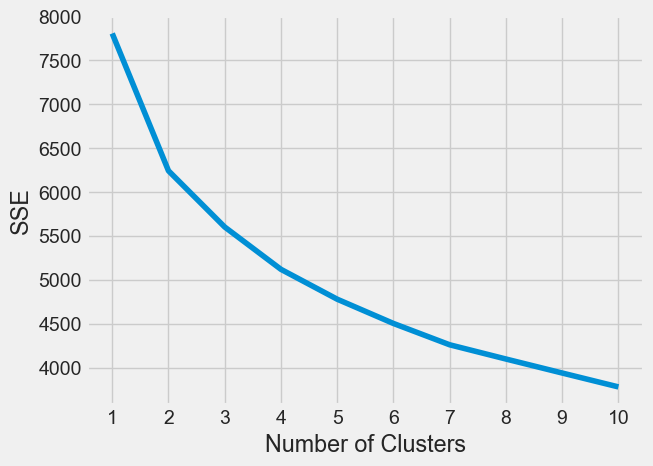

In [43]:
kmeans_kwarg = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state":42
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwarg)
    kmeans.fit(df_demographics_encoded)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

From pages 61 in lecture 3 clustering (KneeLocator)

In [44]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

By using the elbow method, the optimal cluster should be 4.

Idea is from pages 10 in lecture 3 clustering. The code is from pages 30 in lecture 3 clustering

In [45]:
# 5) Fit the K-means model with the optimal number of clusters = 4:
kmeans = KMeans(
    init = "random",
    n_clusters = 4,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(df_demographics_encoded)

print("The lowest SSE value is", kmeans.inertia_, ".")
print("The final locations of the centroid is", kmeans.cluster_centers_, ".")
print("The number of iterations required to converge is", kmeans.n_iter_, ".")
print(kmeans.labels_[:5])


The lowest SSE value is 5119.060834347339 .
The final locations of the centroid is [[-8.60976478e-01 -1.98960330e-01 -5.95328976e-01  7.33496333e-03
   6.60146699e-01  1.76039120e-01  8.31295844e-02  8.06845966e-02
   2.98288509e-01  6.18581907e-01  8.31295844e-02  3.66748166e-02
   1.71149144e-02  9.46210269e-01  1.49144254e-01  3.37408313e-01
   5.13447433e-01  7.87286064e-01  1.46699267e-01  6.60146699e-02]
 [ 6.55335696e-01 -1.84083664e-01  9.19531180e-01  1.54929577e-01
   1.52112676e-01  8.33802817e-01  8.45070423e-03  5.63380282e-03
   9.29577465e-01  6.47887324e-02  5.63380282e-03  6.47887324e-02
   3.09859155e-02  9.04225352e-01  2.64788732e-01  2.95774648e-01
   4.39436620e-01  5.74647887e-01  3.21126761e-01  1.04225352e-01]
 [ 8.55829936e-01 -3.93545985e-01 -8.65891485e-01  2.12885154e-01
   2.38095238e-01  7.42296919e-01  1.96078431e-02 -2.77555756e-17
   9.43977591e-01  5.04201681e-02  5.60224090e-03  1.68067227e-02
   2.52100840e-02  9.57983193e-01  1.00840336e-01  4.5378

In [46]:
# 6) Add cluster labels to the original DataFrame:
df_reviews['Cluster'] = kmeans.labels_


### 4. For every cluster, compute the average review score across the entire cluster. Are there any trends? Note, the answer to this question might be 'No. there are no trends,' depending on what clustering algorithm you choose and what hyper-parameters you select. The point of this exercise is to practice clustering real data.

In [47]:
cluster_summary = df_reviews.groupby('Cluster')[['Rating'] + demographic_columns].mean()
cluster_summary
cluster_counts = df_reviews['Cluster'].value_counts().to_frame(name='Count')
cluster_summary = pd.concat([cluster_summary, cluster_counts], axis=1).sort_values(by="Rating", ascending = False)
print(cluster_summary)

     Rating   Birth Year  Weight (lb)  Height (in)  Count
2  3.994398  1994.509804   181.291501   159.985994    357
1  3.850704  1990.757746   193.230705   185.107042    355
0  3.603912  1962.381418   192.382746   163.792832    409
3  3.566563  1967.715170   254.408669   182.021672    323


In [48]:
ms_counts=df_reviews.groupby(['Cluster'])['Marital Status'].value_counts()
pd.concat([df_reviews.groupby(['Cluster', 'Marital Status'])['Rating'].mean(), ms_counts], axis=1)

Rating  Marital Status
Cluster Marital Status                          
0       Married         3.770370             270
        Single          3.833333              72
        Widow           3.205882              34
        unknown         2.151515              33
1       Married         3.888889              54
        Single          3.847973             296
        Widow           2.666667               3
        unknown         5.000000               2
2       Married         4.164706              85
        Single          3.932075             265
        Widow           4.285714               7
3       Married         3.565543             267
        Single          3.630435              46
        Widow           3.300000              10

In [49]:
hc_counts = df_reviews.groupby(['Cluster'])['Has Children?'].value_counts()
pd.concat([df_reviews.groupby(['Cluster', 'Has Children?'])['Rating'].mean(),hc_counts], axis=1)

Rating  Has Children?
Cluster Has Children?                         
0       No             3.737705            122
        Yes            3.723320            253
        unknown        2.235294             34
1       No             3.833333            330
        Yes            4.043478             23
        unknown        4.500000              2
2       No             4.005935            337
        Yes            3.722222             18
        unknown        4.500000              2
3       No             3.942029             69
        Yes            3.464567            254

In [50]:
v_couns = df_reviews.groupby(['Cluster'])['Vegetarian?'].value_counts()
pd.concat([df_reviews.groupby(['Cluster', 'Vegetarian?'])['Rating'].mean(), v_couns], axis=1)

Rating  Vegetarian?
Cluster Vegetarian?                       
0       No           4.266667           15
        Yes          4.428571            7
        unknown      3.563307          387
1       No           3.521739           23
        Yes          4.090909           11
        unknown      3.866044          321
2       No           4.666667            6
        Yes          3.888889            9
        unknown      3.985380          342
3       No           1.476190           21
        Yes          4.500000            2
        unknown      3.706667          300

In [51]:
aas_counts = df_reviews.groupby(['Cluster'])['Average Amount Spent'].value_counts()
pd.concat([df_reviews.groupby(['Cluster', 'Average Amount Spent'])['Rating'].mean(), aas_counts], axis=1)

Rating  Average Amount Spent
Cluster Average Amount Spent                                
0       High                  4.114754                    61
        Low                   3.253623                   138
        Medium                3.685714                   210
1       High                  3.755319                    94
        Low                   3.838095                   105
        Medium                3.916667                   156
2       High                  4.444444                    36
        Low                   3.740741                   162
        Medium                4.150943                   159
3       High                  3.926471                    68
        Low                   3.425926                   108
        Medium                3.503401                   147

In [52]:
pmt_counts = df_reviews.groupby(['Cluster'])['Preferred Mode of Transport'].value_counts()
pd.concat([df_reviews.groupby(['Cluster', 'Preferred Mode of Transport'])['Rating'].mean(), pmt_counts], axis=1)

Rating  Preferred Mode of Transport
Cluster Preferred Mode of Transport                                       
0       Car Owner                    3.599379                          322
        On Foot                      3.650000                           60
        Public Transit               3.555556                           27
1       Car Owner                    3.867647                          204
        On Foot                      3.947368                          114
        Public Transit               3.459459                           37
2       Car Owner                    4.090909                          154
        On Foot                      3.981595                          163
        Public Transit               3.675000                           40
3       Car Owner                    3.666667                          240
        On Foot                      3.101695                           59
        Public Transit               3.708333                           24

In [53]:
ns_counts = df_reviews.groupby(['Cluster'])['Northwestern Student?'].value_counts()
pd.concat([df_reviews.groupby(['Cluster', 'Northwestern Student?'])['Rating'].mean(), ns_counts], axis=1)

Rating  Northwestern Student?
Cluster Northwestern Student?                                 
0       No                     3.593596                    406
        Yes                    5.000000                      3
1       No                     3.853333                    300
        Yes                    3.836364                     55
2       No                     3.996441                    281
        Yes                    3.986842                     76
3       No                     3.576803                    319
        Yes                    2.750000                      4

From the result, there are not obvious trends of categorcial variables for the 4 cluster we selected. However, there may be a trend in the numerical variable `Birth Year`. For instance, mean ratings for cluster 0 and 1 that reviewers are older are lower than mean ratings for cluster 2 and 3 that reviewers are younger.


## Popularity matching
### 5. What is the most highly rated restaurant? What is the average review score? What is the median review score? Plot a histogram of review scores.

In [54]:
# 1. Group the data by 'Restaurant Name' and compute the mean, median, and count of review scores:
df_review_summary = df_reviews.groupby('Restaurant Name')['Rating'].agg(['mean', 'median', 'count'])


# 3. Compute the average and median review scores across all restaurants:
avg_review_score = df_reviews['Rating'].mean()
median_review_score = df_reviews['Rating'].median()
print(f"Average review score: {avg_review_score:.3f}")
print(f"Median review score: {median_review_score:}")

Average review score: 3.753
Median review score: 4.0


In [55]:
# 3. Find the most highly rated restaurant:
df_review_summary.sort_values(by="mean", ascending=False)[:6]

,mean,median,count
Restaurant Name,,,
Fonda Cantina,5.000000,5.0,6
LeTour,5.000000,5.0,4
World Market,5.000000,5.0,2
Evanston Games & Cafe,5.000000,5.0,1
La Principal,5.000000,5.0,1
Zentli,4.764706,5.0,17


From the table, Fonda Cantina, LeTour, World Market, Evanston Games & Cafe, and La Principal have the highest mean rating of 5.0. 

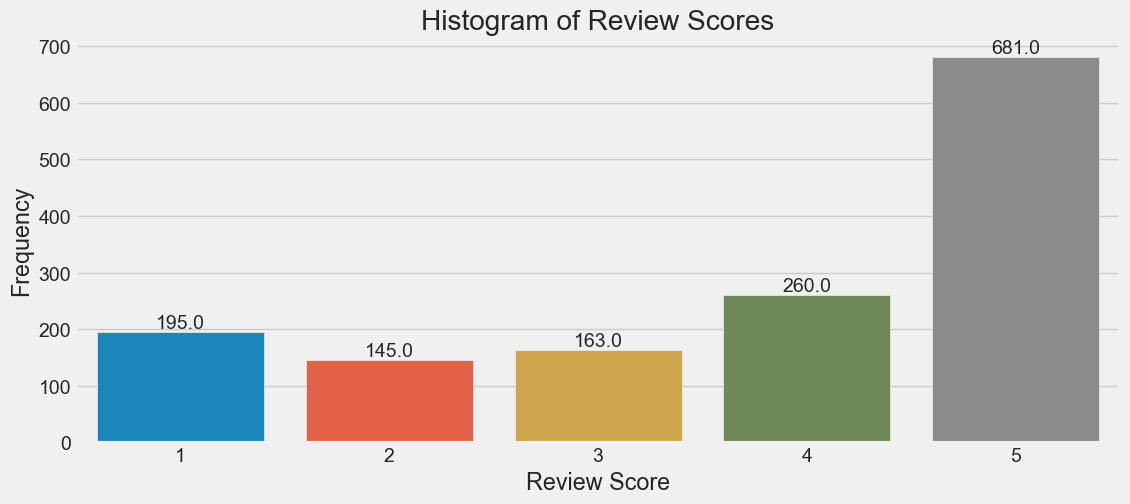

In [56]:
# 4.Plot a histogram of review scores:
plt.figure(figsize=(12, 5))
ax=sns.countplot(data=df_reviews, x='Rating')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Histogram of Review Scores')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.show()

### 6 .What restaurant has received the largest quantitiy of reviews? What is the median number of reviews received?

In [57]:
# 1. the restaurant that has received the largest quantitiy of reviews
largest_quantity_res = df_review_summary['count'].idxmax()
largest_quantity_count = df_review_summary['count'].max()
print(f"The restaurant that has received the largest quantitiy of reviews: {largest_quantity_res} with the count of {largest_quantity_count} reviews")

# 2. median number of reviews received across all restaurants
med_count_re = df_review_summary['count'].median()
print(f"The median number of reviews received: {med_count_re:.0f}")

The restaurant that has received the largest quantitiy of reviews: Campagnola with the count of 48 reviews
The median number of reviews received: 23


In [58]:
df_review_summary[['count']].sort_values(by='count', ascending=False)[:5]

,count
Restaurant Name,
Campagnola,48
Chipotle,41
Cozy Noodles and Rice,38
Taco Diablo,37
Tealicious,34


### 7. Write a simple reccomendation engine wherein a user can input a cusine type and receive a reccommendation based on popularity score. Use this to give reccommendations for Spanish food, Chinese food, Mexican food, and Coffee.



    1) Merge the df_reviews with the df_restaurants to get the restaurant information along with their ratings:

In [59]:
df_merged = pd.merge(df_reviews, df_restaurants, on='Restaurant Name', how='inner')
print("The shape of the merged data is:", df_merged.shape)
print(f"The total number of restaurants in df_reviews is: {len(df_reviews['Restaurant Name'].unique())}")
print(f"The total number of restaurants in df_restaurants is: {len(df_restaurants['Restaurant Name'].unique())}")

The shape of the merged data is: (1436, 21)
The total number of restaurants in df_reviews is: 67
The total number of restaurants in df_restaurants is: 63


In [60]:
diff_res = set(df_reviews['Restaurant Name'].unique()) - set(df_restaurants['Restaurant Name'].unique())
print("The different restaurants between two datasets are:", diff_res)

The different restaurants between two datasets are: {'La Principal', "Clare's Korner", 'Todoroki Sushi', 'World Market'}


In [61]:
df_review_summary.loc[['World Market', 'Todoroki Sushi', 'La Principal', "Clare's Korner"]]

,mean,median,count
Restaurant Name,,,
World Market,5.00,5.0,2
Todoroki Sushi,3.25,3.0,4
La Principal,5.00,5.0,1
Clare's Korner,1.00,1.0,1


Therefore, when we calculate the overall mean ratings and the mean number of rankings, we should use the new dataset df_merged.

    2) Group by 'Restaurant Name' and 'Cuisine' and sorte by mean rating and then count, then compute the mean rating and count of reviews for each restaurant:

In [62]:
df_restaurant_ratings = df_merged.groupby(['Restaurant Name', 'Cuisine'])['Rating'].agg(['mean', 'count']).reset_index().sort_values(by=['mean', 'count'], ascending=False)
df_restaurant_ratings[:5]

,Restaurant Name,Cuisine,mean,count
18,Fonda Cantina,Mexican,5.000000,6
32,LeTour,French,5.000000,4
17,Evanston Games & Cafe,Coffee,5.000000,1
62,Zentli,Mexican,4.764706,17
27,Kilwin's,Chocolate,4.625000,32


    3) Define the shrinkage estimator function: 
    (Using the formula from page 16 in lecture 4 recommendation-systems)
$\frac{N_{\mu}*\mu_s + N_p*\mu_p}{N_{\mu}+N_p}$, where the shrinkage never goes away entirely.

In [63]:
def shrinkage_estimator(df, prior_mean, prior_count):
    df['shrinkage_rating'] = ((df['count'] * df['mean'] + prior_count * prior_mean) / (df['count'] + prior_count))
    return df

    4) Calculate the prior mean and prior count. You can use the overall average rating and mean review count as
    the prior values:

In [64]:
prior_mean = round(df_merged['Rating'].mean(), 3)
prior_count = int(df_restaurant_ratings['count'].mean())
print(f"The overall mean ratings is: {prior_mean}")
print(f"The overall mean review count is: {prior_count}")

The overall mean ratings is: 3.753
The overall mean review count is: 22


    5) Apply the shrinkage estimator function to the restaurant ratings:

In [65]:
df_restaurant_ratings = shrinkage_estimator(df_restaurant_ratings, prior_mean, prior_count)
df_restaurant_ratings.sort_values(by='shrinkage_rating', ascending =False)[:5]

,Restaurant Name,Cuisine,mean,count,shrinkage_rating
27,Kilwin's,Chocolate,4.625000,32,4.269741
62,Zentli,Mexican,4.764706,17,4.194000
53,Table to Stix Ramen,Japanese,4.500000,28,4.171320
57,Tealicious,Bubble Tea,4.441176,34,4.170821
56,Taste of Nepal,South Asian,4.545455,22,4.149227


    6) Define a function to recommend a restaurant based on the input cuisine type and the highest shrinkage
    rating:

In [66]:
def recommend_restaurant(cuisine):
    df_filtered = df_restaurant_ratings[df_restaurant_ratings['Cuisine'] == cuisine]
    highest_rated_restaurant = df_filtered.loc[df_filtered['shrinkage_rating'].idxmax()]
    
    return highest_rated_restaurant['Restaurant Name']

    7) Use the function to recommend restaurants for Spanish food, Chinese food, Mexican food, and Coffee:

In [67]:
cuisines = ['Spanish', 'Chinese', 'Mexican', 'Coffee']

for cuisine in cuisines:
    recommendation = recommend_restaurant(cuisine)
    print(f"Recommended {cuisine} restaurant: {recommendation}")


Recommended Spanish restaurant: Tapas Barcelona
Recommended Chinese restaurant: Joy Yee Noodle
Recommended Mexican restaurant: Zentli
Recommended Coffee restaurant: Philz Coffee


### 8. Implement a shrinkage estimator that shrinks reviews back towards the mean score, scaled by the number of reviews a restaurant has received. See the lecture slides for more details. What restaurant benefits the most from this shrinkage estimation? What restaurant is hurt the most by it? Make a plot that demonstrates changes in review scores due to shrinkage estimation. For example, plot the top k-positive and negative changes in a bar chart. Feel free to make an alterative plot if you want, or to present your results as a table instead.

In [68]:
# 1. create a column 'shrinkage_diff'
df_restaurant_ratings['shrinkage_diff'] = df_restaurant_ratings['shrinkage_rating'] - df_restaurant_ratings['mean']

# 2. Find the restaurants that benefit the most and are hurt the most by the shrinkage estimation:
top_k = 5

## sort by decreasing
df_restaurant_ratings_sorted = df_restaurant_ratings.sort_values(by='shrinkage_diff', ascending=False)

## top k-postive
most_benefited = df_restaurant_ratings_sorted.head(top_k)

## top k-negative
most_hurt = df_restaurant_ratings_sorted.tail(top_k).sort_values(by='shrinkage_diff', ascending=True)

In [69]:
most_benefited[['Restaurant Name', 'Cuisine', 'shrinkage_diff']]

,Restaurant Name,Cuisine,shrinkage_diff
4,Burger King,Burgers,0.914170
16,Evanston Chicken Shack,American,0.620772
11,Cross Rhodes,Mediterranean,0.525381
10,Cozy Noodles and Rice,Thai,0.498030
35,Mumbai Indian Grill,South Asian,0.433266


In [70]:
most_hurt[['Restaurant Name', 'Cuisine', 'shrinkage_diff']]

,Restaurant Name,Cuisine,shrinkage_diff
17,Evanston Games & Cafe,Coffee,-1.192783
32,LeTour,French,-1.055154
18,Fonda Cantina,Mexican,-0.979786
62,Zentli,Mexican,-0.570706
41,Philz Coffee,Coffee,-0.503622


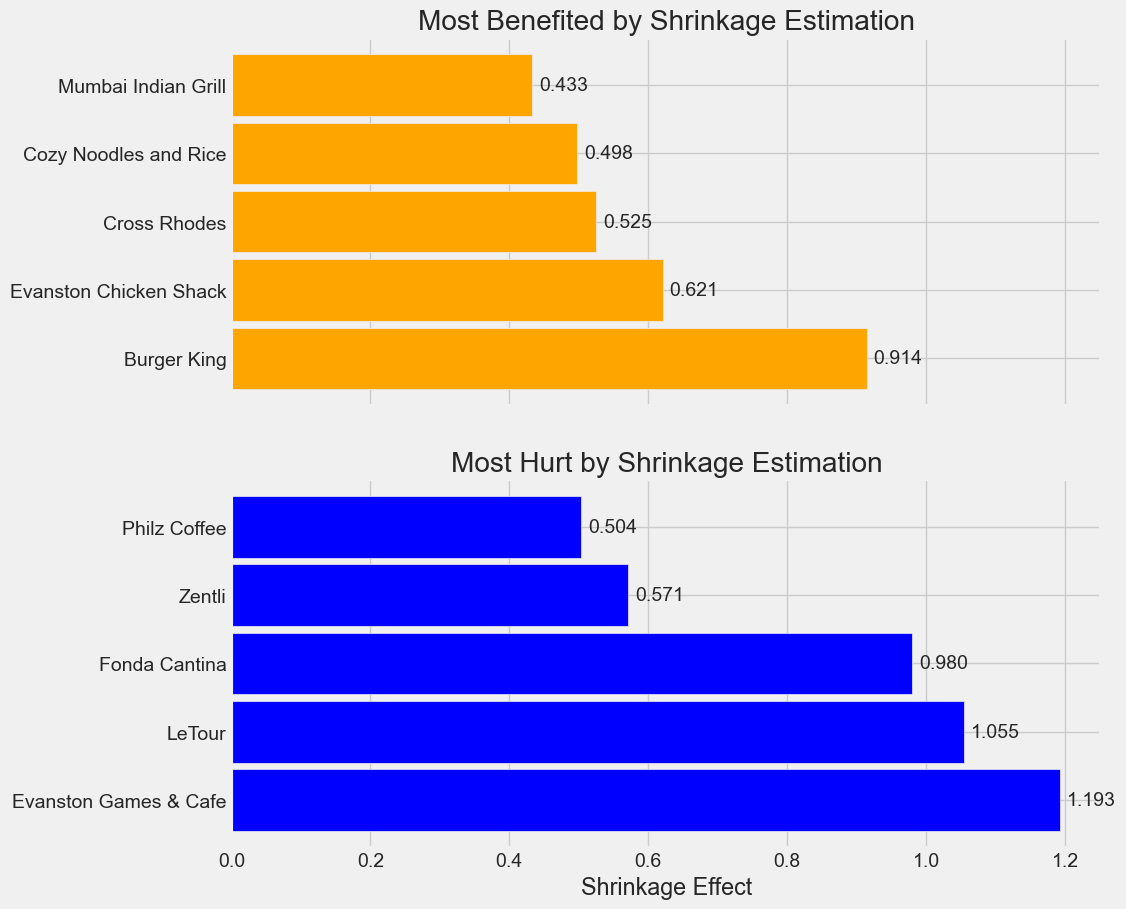

In [71]:
def add_values_to_bars(ax, bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width+0.01, bar.get_y() + bar.get_height() / 2,
                '{:.3f}'.format(width),
                ha='left', va='center')

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ind = np.arange(top_k)
bar_width = 0.9

# Most Benefited
benefited_bars = axes[0].barh(ind, most_benefited['shrinkage_diff'], bar_width, color='orange')
axes[0].set(yticks=ind, yticklabels=most_benefited['Restaurant Name'])
axes[0].set_title('Most Benefited by Shrinkage Estimation')
add_values_to_bars(axes[0], benefited_bars)

# Most Hurt
hurt_bars = axes[1].barh(ind, -most_hurt['shrinkage_diff'], bar_width, color='blue')
axes[1].set(yticks=ind, yticklabels=most_hurt['Restaurant Name'])
axes[1].set_title('Most Hurt by Shrinkage Estimation')
add_values_to_bars(axes[1], hurt_bars)

plt.xlabel('Shrinkage Effect')
plt.show()


Therefore, we can conclude that by applying shrinkage estimators method, Evanston Games& Cafe is hurt the most and Burger King benefits the most.

## Content based filtering

### 9. Using the data in the restaurants.csv table, compute the euclidean distance between every restaurant. Note that you will need to compute a numeric embedding of the categocial variables. Use one-hot encodings.

In [72]:
df_restaurants.head()

,Restaurant Name,Cuisine,Latitude,Longitude,Average Cost,Open After 8pm?,Brief Description
0,Tapas Barcelona,Spanish,42.046736,-87.679043,20,Yes,"Festive, warm space known for Spanish small pl..."
1,Lao Sze Chuan,Chinese,42.048462,-87.679476,20,Yes,"Modern Chinese mainstay, known for an extensiv..."
2,5411 Empanadas,Spanish,42.047310,-87.681849,13,Yes,Known for Argentinean empanadas & special sauc...
3,Hokkaido Ramen,Japanese,42.048482,-87.682722,13,Yes,"Whimsical ramen bar, known for sushi rolls and..."
4,Tomo Japanese Street Food,Japanese,42.049612,-87.682046,20,Yes,Japanese street food cafe with mobile app orde...


In [73]:
df_restaurants['Latitude'].describe()

count    63.000000
mean     42.045750
std       0.007016
min      42.026728
25%      42.045700
50%      42.047054
75%      42.048562
max      42.064481
Name: Latitude, dtype: float64

In [74]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant Name    63 non-null     object 
 1   Cuisine            63 non-null     object 
 2   Latitude           63 non-null     float64
 3   Longitude          63 non-null     object 
 4   Average Cost       63 non-null     int64  
 5   Open After 8pm?    63 non-null     object 
 6   Brief Description  63 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 3.6+ KB


In [75]:
df_restaurants['Longitude'] = df_restaurants['Longitude'].str.replace(',', '').astype('float64')

We should convert the `Longitude` from object to float64.

In [76]:
df_restaurants['Longitude'].describe()

count     1.000000
mean    -87.679153
std            NaN
min     -87.679153
25%     -87.679153
50%     -87.679153
75%     -87.679153
max     -87.679153
Name: Longitude, dtype: float64

In [77]:
df_restaurants.shape

(63, 7)

In [78]:
print("The number of categories for Cuisine is:", df_restaurants["Cuisine"].unique().shape[0])
print("The number of categories for Average Cost is:", df_restaurants["Average Cost"].unique().shape[0])
print("The number of categories for Open After 8pm? is:", df_restaurants["Open After 8pm?"].unique().shape[0])
print("The number of categories for Brief Description is:", df_restaurants["Brief Description"].unique().shape[0])

The number of categories for Cuisine is: 24
The number of categories for Average Cost is: 5
The number of categories for Open After 8pm? is: 2
The number of categories for Brief Description is: 63


In [79]:
df_restaurants["Average Cost"].unique()

array([20, 13, 27, 50, 40])

Although `Average Cost` has only five integer values, it represents an ordinal variable with a natural order (higher values indicate a higher cost). One-hot encoding is not necessary in this case because the numeric values already capture the ordinal relationship between the categories.

Using one-hot encoding for `Average Cost` would increase the dimensionality of the data and might not provide additional benefits in terms of distance calculation. The integer values of 'Average Cost' convey the cost relationship and, when normalized, can be directly used in distance computations without losing meaningful information.

Hence, we transformed `Cuisine` to one-hot format and `Open After 8pm?` to a binary variable. And we scaled the numerical variables `Average Cost` because `Latitude` and `Longitude` seem no difference among restaurants. It is because they are all located in Evanston.


In [80]:
# Map 'Open After 8pm?' to binary values
df_restaurants['Open After 8pm?'] = df_restaurants['Open After 8pm?'].replace(['Yes', 'No'], [1, 0])

# One-hot encoding for 'Cuisine'
df_restaurants_encoded = pd.get_dummies(df_restaurants, columns=['Cuisine'])

# Drop 'Restaurant Name' and 'Brief Description'
df_restaurants_encoded = df_restaurants_encoded.drop(['Restaurant Name', 'Brief Description'], axis=1)

# Drop `Latitude` and `Longitude`
df_restaurants_encoded = df_restaurants_encoded.drop(['Latitude', 'Longitude'], axis=1)

# Normalize numeric variables
scaler = StandardScaler()
df_restaurants_encoded[['Average Cost']] = scaler.fit_transform(df_restaurants_encoded[['Average Cost']])
df_restaurants_encoded.head()

,Average Cost,Open After 8pm?,Cuisine_American,Cuisine_BBQ,Cuisine_Breakfast,Cuisine_Brewery,Cuisine_Bubble Tea,Cuisine_Burgers,Cuisine_Chinese,Cuisine_Chocolate,...,Cuisine_Korean,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Pizza,Cuisine_Salad,Cuisine_Seafood,Cuisine_South Asian,Cuisine_Spanish,Cuisine_Thai,Cuisine_Vegetarian
0,0.030158,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.030158,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.801060,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-0.801060,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.030158,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# define euclidean_distance function
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

# Calculate the distance matrix
n_restaurants = df_restaurants_encoded.shape[0]
distance_matrix = np.zeros((n_restaurants, n_restaurants))

for i in range(n_restaurants):
    for j in range(n_restaurants):
        distance_matrix[i, j] = euclidean_distance(df_restaurants_encoded.iloc[i], df_restaurants_encoded.iloc[j])

# Print the distance matrix
print(distance_matrix)

[[0.         1.41421356 0.83121777 ... 1.73205081 1.73205081 1.6404033 ]
 [1.41421356 0.         1.6404033  ... 1.73205081 1.73205081 1.6404033 ]
 [0.83121777 1.6404033  0.         ... 1.9211775  1.9211775  1.41421356]
 ...
 [1.73205081 1.73205081 1.9211775  ... 0.         1.41421356 1.9211775 ]
 [1.73205081 1.73205081 1.9211775  ... 1.41421356 0.         1.9211775 ]
 [1.6404033  1.6404033  1.41421356 ... 1.9211775  1.9211775  0.        ]]


### 10. Repete the previous step, using cosine distance this time.


In [82]:
# define cosine similarity metric:

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

# Calculate the similarity matrix
similarity_matrix = np.zeros((n_restaurants, n_restaurants))

for i in range(n_restaurants):
    for j in range(n_restaurants):
        similarity_matrix[i, j] = cosine_similarity(df_restaurants_encoded.iloc[i], df_restaurants_encoded.iloc[j])

# Print the similarity matrix
print(similarity_matrix)

[[ 1.00000000e+00  5.00227266e-01  8.59403164e-01 ...  6.42660047e-04
   6.42660047e-04  4.24447751e-01]
 [ 5.00227266e-01  1.00000000e+00  4.24447751e-01 ...  6.42660047e-04
   6.42660047e-04  4.24447751e-01]
 [ 8.59403164e-01  4.24447751e-01  1.00000000e+00 ... -1.48567026e-02
  -1.48567026e-02  6.21455516e-01]
 ...
 [ 6.42660047e-04  6.42660047e-04 -1.48567026e-02 ...  1.00000000e+00
   9.08652071e-04 -1.48567026e-02]
 [ 6.42660047e-04  6.42660047e-04 -1.48567026e-02 ...  9.08652071e-04
   1.00000000e+00 -1.48567026e-02]
 [ 4.24447751e-01  4.24447751e-01  6.21455516e-01 ... -1.48567026e-02
  -1.48567026e-02  1.00000000e+00]]


### 11. Write a script that takes a user and returns a reccommendation using content based filtering. This script should take a user, find restaurants the user liked, and then find similar restaurants using euclidean and cosine distances. For one user and one selected restaurant, plot the top reccommendations by the system. Alternatively, you may show a simple table of the top reccommendations. The point is the show your system's output in some way. I don't care how you do it.

In [83]:
df_reviews['Reviewer Name'].head()

0          Connie Neal
1    Jacquelyn Rigatti
2    Jacquelyn Rigatti
3    Jacquelyn Rigatti
4    Jacquelyn Rigatti
Name: Reviewer Name, dtype: object

In [84]:

# Calculate the similarity between liked restaurants and all other restaurants
def get_similar_restaurants(user_name, distance_metric, K, reverse):
    liked_restaurants = df_reviews[df_reviews['Reviewer Name']==user_name][['Restaurant Name', 'Rating']].sort_values(by='Rating', ascending=False).iloc[0][0]
    
    similar_restaurants = []

    liked_restaurant_index = df_restaurants[df_restaurants['Restaurant Name'] == liked_restaurants].index[0]
    liked_restaurant_encoded = df_restaurants_encoded.iloc[liked_restaurant_index]

    similarities = []
    for i, restaurant_encoded in df_restaurants_encoded.iterrows():
        similarity = distance_metric(liked_restaurant_encoded, restaurant_encoded)
        similarities.append((i, similarity))

    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=reverse)[1:K+1]
    similar_restaurants.extend([df_restaurants.iloc[i]['Restaurant Name'] for i, _ in sorted_similarities])
        
    return similar_restaurants

# Recommend restaurants using Euclidean distance

# Select a user
user_name = 'Jacquelyn Rigatti'

K = 5
euclidean_recommendations = get_similar_restaurants(user_name, euclidean_distance, K, reverse=False)
print("Euclidean Recommendations:")
print(euclidean_recommendations)

# Recommend restaurants using Cosine similarity
cosine_recommendations = get_similar_restaurants(user_name, cosine_similarity, K, reverse=True)
print("\nCosine Recommendations:")
print(cosine_recommendations)


Euclidean Recommendations:
['Alcove', 'LeTour', 'Oceanique', 'Graduate Homestead Room', 'Kansaku']

Cosine Recommendations:
['Alcove', 'LeTour', 'Oceanique', 'Graduate Homestead Room', 'Kansaku']


In [85]:
# Create a DataFrame for Euclidean recommendations
euclidean_recommendations_df = pd.DataFrame(euclidean_recommendations, columns=['Restaurant Name'])
euclidean_recommendations_df['Similarity Metric'] = 'Euclidean'

# Create a DataFrame for Cosine recommendations
cosine_recommendations_df = pd.DataFrame(cosine_recommendations, columns=['Restaurant Name'])
cosine_recommendations_df['Similarity Metric'] = 'Cosine'

# Combine the DataFrames and display the top recommendations
top_recommendations = pd.concat([euclidean_recommendations_df[1:], cosine_recommendations_df[1:]], ignore_index=True)
top_recommendations

,Restaurant Name,Similarity Metric
0,LeTour,Euclidean
1,Oceanique,Euclidean
2,Graduate Homestead Room,Euclidean
3,Kansaku,Euclidean
4,LeTour,Cosine
5,Oceanique,Cosine
6,Graduate Homestead Room,Cosine
7,Kansaku,Cosine


In [86]:
df_restaurants_encoded

,Average Cost,Open After 8pm?,Cuisine_American,Cuisine_BBQ,Cuisine_Breakfast,Cuisine_Brewery,Cuisine_Bubble Tea,Cuisine_Burgers,Cuisine_Chinese,Cuisine_Chocolate,...,Cuisine_Korean,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Pizza,Cuisine_Salad,Cuisine_Seafood,Cuisine_South Asian,Cuisine_Spanish,Cuisine_Thai,Cuisine_Vegetarian
0,0.030158,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.030158,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.801060,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-0.801060,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.030158,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-0.801060,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
59,-0.801060,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0.030158,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
61,0.030158,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In this function, supposed we want to recommend Jacquelyn Rigatti a restaruant given that he/she likes 'Barn Steakhouse' the most, we utilized two matrics, Euclidean and Cosine distance, to get the top 5 restaurants that have the highest similarity. For both Euclidean Recommendations and Cosine Recommendations, we have 'Alcove', 'Graduate Homestead Room', 'LeTour', 'Barn Steakhouse', and 'Oceanique'. In conclusion, two distance metric may yield different result.

## Natural language analysis

### 12. Consider the 'brief description' column of the Restaurants dataset. Augement this description by attaching the restaurant's cusine type to the end of the description. For example, with Tapas Barcelona the description is: 'Festive, warm space known for Spanish small plates is adorned with colorful modern art & posters.' The Cusine is 'Spanish.' The augemented description would thus be: 'Festive, warm space known for Spanish small plates is adorned with colorful modern art & posters. Spanish' Name this variable "Augmented Description."

In [87]:
# Augment the 'Brief Description' column with the 'Cuisine' column
df_restaurants['Augmented Description'] = df_restaurants['Brief Description'] + ' ' + df_restaurants['Cuisine']

# Display the first few rows of the updated DataFrame
pd.options.display.max_colwidth = 1000
## Now the entire sentence should be displayed:
df_restaurants[['Augmented Description']].head()

,Augmented Description
0,"Festive, warm space known for Spanish small plates is adorned with colorful modern art & posters. Spanish"
1,"Modern Chinese mainstay, known for an extensive selection of classic entrees in a stylish airy interior making it a festive space. Chinese"
2,"Known for Argentinean empanadas & special sauces, plus beer & wine in a laid-back setting. Spanish"
3,"Whimsical ramen bar, known for sushi rolls and garlic tonkatsu ramen Japanese"
4,"Japanese street food cafe with mobile app ordering, known for hearty ramen and udon bowls. Japanese"


We created a new column `Augmented Description` that adds the corresponding `Cuisine` type to the `Brief Description`.

### 13. Compute the Jaccard matrix using the elements of Augemented Description. In the Jaccard matrix, entry d_ij should be the Jaccard distance between restuarant i's augmented description and restaurant j's augmented descirpiton.

The code of Jaccard_Similarity is from pages 55 in lecture 4 notes.
$J(doc1, doc2) = \frac{length(intersection)}{length(union)}$

In [88]:
# define the Jaccard distance function:
def Jaccard_Similarity(doc1, doc2):
    # Remove punctuation from the documents
    translator = str.maketrans('', '', string.punctuation)
    doc1 = doc1.translate(translator)
    doc2 = doc2.translate(translator)    
    
    # List the unique words in a document
    # all lower case(.lower()) and split a sentence to unique words (set(.split()))
    words_doc1 = set(doc1.lower().split())
    words_doc2 = set(doc2.lower().split())
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)
    
    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
    
    # Calculate Jaccard similarity score
    # using length of intersection set divided by length of union
    return float(len(intersection) / len(union))

In [89]:
# Get the list of augmented descriptions
## tolist() is to extract all of the restaurant descriptions from the DataFrame and returning them as a Python list.
augmented_descriptions = df_restaurants['Augmented Description'].tolist()

# Initialize an empty Jaccard matrix of size n x n, where n is the number of restaurants
n = len(augmented_descriptions)
jaccard_matrix = np.zeros((n, n))

# Compute the Jaccard matrix
for i in range(n):
    for j in range(n):
        jaccard_matrix[i, j] = Jaccard_Similarity(augmented_descriptions[i], augmented_descriptions[j])
        
# Create a DataFrame for better visualization
restaurant_names = df_restaurants['Restaurant Name'].tolist()
jaccard_matrix_df = pd.DataFrame(jaccard_matrix, columns=restaurant_names, index=restaurant_names)

# the Jaccard matrix
jaccard_matrix_df

,Tapas Barcelona,Lao Sze Chuan,5411 Empanadas,Hokkaido Ramen,Tomo Japanese Street Food,Kuni's Japanese Restaurant,Kansaku,Taco Diablo,Fridas,Edzo's Burger Shop,...,Pâtisserie Coralie,Cozy Noodles and Rice,Nakorn,Prairie Moon,Hecky's BBQ,Soban Korea,Burger King,Sarah's Brick Oven,Leonidas Cafe Chocolaterie,Evanston Games & Cafe
Tapas Barcelona,1.000000,0.166667,0.115385,0.083333,0.111111,0.222222,0.120000,0.086957,0.000000,0.071429,...,0.062500,0.142857,0.000000,0.068966,0.074074,0.080000,0.090909,0.115385,0.071429,0.095238
Lao Sze Chuan,0.166667,1.000000,0.133333,0.068966,0.060606,0.187500,0.178571,0.071429,0.000000,0.093750,...,0.147059,0.088235,0.033333,0.125000,0.062500,0.066667,0.074074,0.062500,0.129032,0.076923
5411 Empanadas,0.115385,0.133333,1.000000,0.086957,0.074074,0.142857,0.173913,0.090909,0.040000,0.160000,...,0.222222,0.107143,0.000000,0.153846,0.076923,0.130435,0.095238,0.076923,0.160000,0.100000
Hokkaido Ramen,0.083333,0.068966,0.086957,1.000000,0.238095,0.208333,0.200000,0.105263,0.000000,0.083333,...,0.071429,0.076923,0.000000,0.125000,0.086957,0.150000,0.111111,0.136364,0.083333,0.187500
Tomo Japanese Street Food,0.111111,0.060606,0.074074,0.238095,1.000000,0.178571,0.120000,0.086957,0.000000,0.071429,...,0.096774,0.103448,0.000000,0.107143,0.074074,0.125000,0.090909,0.208333,0.071429,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Soban Korea,0.080000,0.066667,0.130435,0.150000,0.125000,0.111111,0.086957,0.100000,0.043478,0.080000,...,0.068966,0.074074,0.000000,0.120000,0.083333,1.000000,0.105263,0.130435,0.080000,0.176471
Burger King,0.090909,0.074074,0.095238,0.111111,0.090909,0.080000,0.100000,0.117647,0.000000,0.263158,...,0.076923,0.083333,0.000000,0.086957,0.095238,0.105263,1.000000,0.095238,0.090909,0.133333
Sarah's Brick Oven,0.115385,0.062500,0.076923,0.136364,0.208333,0.142857,0.080000,0.090909,0.000000,0.074074,...,0.100000,0.107143,0.000000,0.071429,0.076923,0.130435,0.095238,1.000000,0.074074,0.222222
Leonidas Cafe Chocolaterie,0.071429,0.129032,0.160000,0.083333,0.071429,0.137931,0.166667,0.086957,0.000000,0.111111,...,0.214286,0.103448,0.000000,0.107143,0.074074,0.080000,0.090909,0.074074,1.000000,0.150000


In [90]:
jaccard_matrix_df.loc['Lao Sze Chuan'].sort_values(ascending=False)[:6]

Lao Sze Chuan                 1.000000
Joy Yee Noodle                0.285714
Kabul House                   0.225806
Tealicious                    0.222222
Oceanique                     0.193548
Kuni's Japanese Restaurant    0.187500
Name: Lao Sze Chuan, dtype: float64

### 14. Write code that takes as input a word. The code should take this word and compute the TF-IDF score for each restaurant's Augmented Description. Using this function, which restaurant has the highest TF-IDF score for the word 'cozy?' What about for the word 'Chinese?'

From pages 61 to 68 in lecture 4 notes, TF-IDF can deal with the problem of frequent unmeaning words like "is" and "the" that might be problematic in Jaccard distance. TF-IDF is Term Frequency - Inverse Document Frequency, which is a corpus-wide metric.

1) TF-IDF = TF * IDF

2) Tf(t) = $\frac{Number\ of\ times\ t\ appears\ in\ document}{Total\ number\ of\ terms\ in\ the\ document}$, which measures how many times does a term occur in a document.

3) IDF(t)= $\ln(\frac{Total\ number\ of\ documents}{Total\ number\ of\ documennts\ with\ term\ t})$, which measures how important or unique a term is overall.

Words with higher TF-IDF scores are more important in the document and are less common across the entire corpus. Words with lower TF-IDF scores are less important in the document and are more common across the entire corpus.

We used the package TfidfVectorizer from sklearn to calculate the TF-IDF scores for each word in each restaurant.

In [91]:
corpus = df_restaurants['Augmented Description'].tolist()

# Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the corpus
X = vectorizer.fit_transform(corpus)

# Create a DataFrame with the TF-IDF scores
tfidf_scores = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

def find_highest_tfidf(word):
    if word in tfidf_scores.columns:
        # Find the restaurant index with the highest TF-IDF score for the given word
        highest_tfidf_index = tfidf_scores[word].idxmax()

        # Get the restaurant name and the highest TF-IDF score
        highest_tfidf_restaurant = df_restaurants.loc[highest_tfidf_index, 'Restaurant Name']
        highest_tfidf_score = tfidf_scores.loc[highest_tfidf_index, word]

        return highest_tfidf_restaurant, highest_tfidf_score
    else:
        return None, None

# Find the highest TF-IDF score for the word 'cozy'
cozy_restaurant, cozy_score = find_highest_tfidf('cozy')
print(f"The restaurant with the highest TF-IDF score for the word 'cozy' is '{cozy_restaurant}' with a score of {cozy_score:.3f}.")

# Find the highest TF-IDF score for the word 'Chinese'
chinese_restaurant, chinese_score = find_highest_tfidf('chinese')
print(f"The restaurant with the highest TF-IDF score for the word 'Chinese' is '{chinese_restaurant}' with a score of {chinese_score:.3f}.")


The restaurant with the highest TF-IDF score for the word 'cozy' is 'Taste of Nepal' with a score of 0.288.
The restaurant with the highest TF-IDF score for the word 'Chinese' is 'Lao Sze Chuan' with a score of 0.420.


In [92]:
tfidf_scores

,acclaimed,adorned,afghan,airy,alongside,also,american,amid,amy,an,...,well,whimsical,will,wine,wines,with,wood,wraps,yet,your
0,0.0,0.261765,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.162453,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.264255,0.000000,0.0,0.0,0.0,0.0,0.210035,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.300948,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.294627,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.166472,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
59,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.364175,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
60,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.166701,0.0,0.0,0.0,0.0
61,0.0,0.000000,0.0,0.000000,0.288832,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### 15. Make a list of the 100 most popular words in the Augmented Description column. Write two nested for loops. First, loop over each of the restaurant descriptions. For each of the restaurant descriptions, also loop over every word in the 100 most popular words list. Compute the TF-IDF score for that word. The result should be 64 TF-IDF vectors of length 100, one for each restaurant.



Define the 3 functions, 1) TF, 2) IDF, 3) TF-IDF

The code is from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76.

In [93]:
# 1) TF
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

# 2) IDF
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

# 3) TF-IDF
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [94]:
# use sklearn pacakage TfidfVectorizer()
corpus = df_restaurants['Augmented Description'].tolist()

# Count the occurrences of words in the corpus
word_counts = Counter()
for description in corpus:
    # Remove punctuation from the documents
    translator = str.maketrans('', '', string.punctuation)
    description = description.translate(translator)
    words = description.lower().split()
    word_counts.update(words)

# Find the 100 most common words
top_100_words = word_counts.most_common(100)
top_100_words_only = []
for word in top_100_words:
    top_100_words_only.append(word[0])

# Initialize a TfidfVectorizer object with the custom vocabulary
vectorizer = TfidfVectorizer(vocabulary=top_100_words_only)

# Fit the vectorizer to the corpus and compute the TF-IDF scores
X = vectorizer.fit_transform(corpus)

# Convert the sparse matrix 'X' to a dense array and create a DataFrame with TF-IDF scores
tfidf_scores_top_100 = pd.DataFrame(X.toarray(), columns=top_100_words_only)

# The DataFrame 'tfidf_scores_top_100' contains 64 TF-IDF vectors of length 100, one for each restaurant
tfidf_scores_top_100

,for,known,a,in,and,with,american,space,plus,chain,...,favorites,serving,burger,shakes,surrounds,ingredients,storefront,grub,its,sidewalk
0,0.077948,0.076739,0.0,0.000000,0.000000,0.187418,0.0,0.192930,0.0000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.076165,0.074983,0.0,0.130205,0.000000,0.000000,0.0,0.188516,0.0000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.142822,0.140606,0.0,0.244157,0.000000,0.000000,0.0,0.000000,0.3535,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.091885,0.090460,0.0,0.000000,0.209221,0.000000,0.0,0.000000,0.0000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.100169,0.098615,0.0,0.000000,0.228083,0.240846,0.0,0.000000,0.0000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.122194,0.120298,0.0,0.000000,0.278233,0.000000,0.0,0.000000,0.0000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
59,0.108094,0.212833,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.275799,...,0.0,0.0,0.0,0.418784,0.0,0.0,0.000000,0.0,0.0,0.0
60,0.091138,0.089724,0.0,0.000000,0.415038,0.219131,0.0,0.000000,0.0000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
61,0.094552,0.093085,0.0,0.161638,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.366319,0.0,0.0,0.0


In [95]:
top_100_words[0:5]

[('for', 64), ('known', 62), ('a', 28), ('in', 27), ('and', 19)]

The 5 most popular words among all documents are 'for', 'known', 'a', 'in', and 'and'. These words have lower IF-IDF valus.

### 16. Similar to step 13, compute the TF-IDF distance matrix. In this matrix, d_ij is the distance between the TF-IDF vectors for restaurants i and j.

In [96]:
# Convert the tfidf_scores_top_100 DataFrame to a NumPy array
tfidf_scores_top_100_np = tfidf_scores_top_100.to_numpy()

# Initialize an empty matrix with zeros
n = tfidf_scores_top_100_np.shape[0]
tfidf_distance_matrix = np.zeros((n, n))

# Loop over the TF-IDF vectors and compute the cosine similarity
for i, vector_i in enumerate(tfidf_scores_top_100_np):
    for j, vector_j in enumerate(tfidf_scores_top_100_np):
        tfidf_distance_matrix[i, j] = cosine_similarity(vector_i, vector_j)
        
# Create a DataFrame for better visualization
restaurant_names = df_restaurants['Restaurant Name'].tolist()
tfidf_distance_matrix_df = pd.DataFrame(tfidf_distance_matrix, columns=restaurant_names, index=restaurant_names)

# Display the DataFrame
tfidf_distance_matrix_df

,Tapas Barcelona,Lao Sze Chuan,5411 Empanadas,Hokkaido Ramen,Tomo Japanese Street Food,Kuni's Japanese Restaurant,Kansaku,Taco Diablo,Fridas,Edzo's Burger Shop,...,Pâtisserie Coralie,Cozy Noodles and Rice,Nakorn,Prairie Moon,Hecky's BBQ,Soban Korea,Burger King,Sarah's Brick Oven,Leonidas Cafe Chocolaterie,Evanston Games & Cafe
Tapas Barcelona,1.000000,0.214107,0.356126,0.014104,0.060514,0.241407,0.057184,0.015789,0.000000,0.015028,...,0.013010,0.144288,0.000000,0.013697,0.032323,0.018756,0.024758,0.055058,0.014513,0.021052
Lao Sze Chuan,0.214107,1.000000,0.053212,0.013781,0.015024,0.169442,0.076048,0.015428,0.000000,0.036477,...,0.105628,0.030301,0.090399,0.072064,0.031583,0.018327,0.024192,0.013669,0.035227,0.020571
5411 Empanadas,0.356126,0.053212,1.000000,0.025842,0.028172,0.059715,0.063312,0.028930,0.084723,0.154065,...,0.230048,0.056820,0.000000,0.126875,0.059224,0.034367,0.045364,0.025632,0.066057,0.038574
Hokkaido Ramen,0.014104,0.013781,0.025842,1.000000,0.532169,0.320096,0.296208,0.018612,0.000000,0.017715,...,0.015336,0.014716,0.000000,0.122393,0.038102,0.080322,0.029185,0.103325,0.017108,0.090155
Tomo Japanese Street Food,0.060514,0.015024,0.028172,0.532169,1.000000,0.464264,0.392691,0.020290,0.000000,0.019313,...,0.114106,0.063140,0.000000,0.094775,0.041537,0.087563,0.125302,0.270136,0.018651,0.255873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Soban Korea,0.018756,0.018327,0.034367,0.080322,0.087563,0.074717,0.021806,0.024752,0.094494,0.023559,...,0.020395,0.019570,0.000000,0.108550,0.050670,1.000000,0.038812,0.137407,0.022752,0.119893
Burger King,0.024758,0.024192,0.045364,0.029185,0.125302,0.027148,0.028784,0.032672,0.000000,0.526031,...,0.026921,0.025832,0.000000,0.111621,0.059454,0.038812,1.000000,0.028948,0.030032,0.043563
Sarah's Brick Oven,0.055058,0.013669,0.025632,0.103325,0.270136,0.141149,0.016264,0.018461,0.000000,0.017571,...,0.103818,0.057447,0.000000,0.016014,0.037792,0.137407,0.028948,1.000000,0.016969,0.297611
Leonidas Cafe Chocolaterie,0.014513,0.035227,0.066057,0.017108,0.018651,0.039533,0.041914,0.019153,0.000000,0.045283,...,0.281435,0.037616,0.000000,0.016614,0.039208,0.022752,0.030032,0.016969,1.000000,0.249470


The reasion for using the cosine similarity is that it's a commonly used metric for comparing text documents in the context of TF-IDF, and the magnitude doesn't matter here.
For instance, we want to find the top 5 restaurant that has highest cosine similarity with 'Tapas Barcelona' in this TF-IDF distane matrix, we can first get the vector of 'Tapas Barcelona' and find the highest similarity without including 'Tapas Barcelona' itself. From the result, the top 5 restaurants and their cosine similarity are shown below.

### 17. Using BERT or Word2Vec, embed the restaurant descriptions into a vectorized representation. Similar to steps 13 and 16, compute an Embedding-Distance matrix, where d_ij is the distance between embedding vectors of restaurants i and j.



IF-IDF only consider a single word. It has issues when embedding an entire sentence. Word2vec & BERT do not compute the distance between two documents. Instead, they focus on learning an embedding f : sentence → $c_i$ 𝜖 $R^n$

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model that is capable of understanding the context and semantics of a given text. It is based on the Transformer architecture and has been trained on a large corpus of text. In the provided code, we use BERT to generate embeddings (vectorized representations) for the `Augmented Description` of each restaurant. These embeddings can be used to compute the similarity between different restaurant descriptions.

In [97]:

# Load the pre-trained BERT model and tokenizer
# The tokenizer is responsible for converting the input text into tokens that BERT can understand.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a text
def get_bert_embedding(text):
    tokens = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True)
    with torch.no_grad():
        outputs = model(tokens)
# The last_hidden_state attribute of the model's output represents the embeddings for each token in the input text.
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Get BERT embeddings for the augmented descriptions
augmented_descriptions = df_restaurants['Augmented Description'].tolist()
embeddings = [get_bert_embedding(description) for description in augmented_descriptions]

# Calculate the distance matrix using cosine similarity
embedding_distance_matrix = np.zeros((len(embeddings), len(embeddings)))

for i, emb_i in enumerate(embeddings):
    for j, emb_j in enumerate(embeddings):
        embedding_distance_matrix[i, j] = cosine_similarity(emb_i, emb_j)

# Convert the distance matrix to a DataFrame for easier visualization
embedding_distance_matrix_df = pd.DataFrame(embedding_distance_matrix,
                                            index=df_restaurants['Restaurant Name'],
                                            columns=df_restaurants['Restaurant Name'])



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
embedding_distance_matrix_df

Restaurant Name,Tapas Barcelona,Lao Sze Chuan,5411 Empanadas,Hokkaido Ramen,Tomo Japanese Street Food,Kuni's Japanese Restaurant,Kansaku,Taco Diablo,Fridas,Edzo's Burger Shop,...,Pâtisserie Coralie,Cozy Noodles and Rice,Nakorn,Prairie Moon,Hecky's BBQ,Soban Korea,Burger King,Sarah's Brick Oven,Leonidas Cafe Chocolaterie,Evanston Games & Cafe
Restaurant Name,,,,,,,,,,,,,,,,,,,,,
Tapas Barcelona,1.000000,0.768616,0.697091,0.609041,0.689924,0.790015,0.743963,0.754128,0.765956,0.710353,...,0.755309,0.798368,0.789816,0.793884,0.718605,0.732037,0.692650,0.723959,0.703155,0.711838
Lao Sze Chuan,0.768616,1.000000,0.776983,0.716455,0.769849,0.821743,0.825644,0.733696,0.771239,0.743150,...,0.831796,0.770179,0.857805,0.827356,0.727739,0.774621,0.714024,0.747148,0.783624,0.674759
5411 Empanadas,0.697091,0.776983,1.000000,0.745221,0.765025,0.761058,0.791522,0.854400,0.801225,0.760674,...,0.788874,0.725780,0.737376,0.790994,0.774757,0.776550,0.761421,0.782322,0.792847,0.680029
Hokkaido Ramen,0.609041,0.716455,0.745221,1.000000,0.851739,0.754174,0.801534,0.722489,0.735253,0.715309,...,0.747135,0.686512,0.671259,0.704538,0.778361,0.761417,0.776924,0.752302,0.759049,0.682387
Tomo Japanese Street Food,0.689924,0.769849,0.765025,0.851739,1.000000,0.825697,0.847829,0.757962,0.784838,0.776023,...,0.809953,0.798820,0.727360,0.775549,0.802237,0.848230,0.811580,0.812113,0.794417,0.798422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Soban Korea,0.732037,0.774621,0.776550,0.761417,0.848230,0.835869,0.801852,0.759963,0.781472,0.785189,...,0.782471,0.808056,0.746095,0.793660,0.781100,1.000000,0.816717,0.797880,0.734793,0.757224
Burger King,0.692650,0.714024,0.761421,0.776924,0.811580,0.772569,0.761039,0.787281,0.837602,0.897850,...,0.812384,0.730095,0.754614,0.805166,0.823583,0.816717,1.000000,0.780398,0.777772,0.729348
Sarah's Brick Oven,0.723959,0.747148,0.782322,0.752302,0.812113,0.802381,0.771179,0.755206,0.782752,0.731889,...,0.797170,0.739406,0.707464,0.788578,0.805131,0.797880,0.780398,1.000000,0.764189,0.757889


### 18. Come up with a methd of comparing the reccommendations made by Jaccard distance, TF-IDF distance, and BERT/Word2Vec distance. Expalin why this method makes sense. What distance metric does the best under your proposed compairson method? Be sure to visualize your results or present a table as evidence.

In [99]:
print(embedding_distance_matrix_df.loc['Lao Sze Chuan'].sort_values(ascending=False)[1:7])
print(tfidf_distance_matrix_df.loc['Lao Sze Chuan'].sort_values(ascending=False)[1:7])
print(jaccard_matrix_df.loc['Lao Sze Chuan'].sort_values(ascending=False)[1:7])

Restaurant Name
Shangri-La Evanston    0.863333
Joy Yee Noodle         0.860600
Nakorn                 0.857805
Oceanique              0.849538
Kabul House            0.839919
Pâtisserie Coralie     0.831796
Name: Lao Sze Chuan, dtype: float64
Joy Yee Noodle         0.460234
Peppercorns Kitchen    0.263919
Oceanique              0.250736
Kabul House            0.245645
Shangri-La Evanston    0.228871
Tapas Barcelona        0.214107
Name: Lao Sze Chuan, dtype: float64
Joy Yee Noodle                0.285714
Kabul House                   0.225806
Tealicious                    0.222222
Oceanique                     0.193548
Kuni's Japanese Restaurant    0.187500
Kansaku                       0.178571
Name: Lao Sze Chuan, dtype: float64


In [100]:
bert_mean = embedding_distance_matrix_df.loc['Lao Sze Chuan'].mean()
tfidf_mean = tfidf_distance_matrix_df.loc['Lao Sze Chuan'].mean()
jac_mean = jaccard_matrix_df.loc['Lao Sze Chuan'].mean()
print("Bert mean is", bert_mean)
print("TF-IDF mean is", tfidf_mean)
print("Jaccard mean is", jac_mean)

Bert mean is 0.77321100518817
TF-IDF mean is 0.09064186630427808
Jaccard mean is 0.12148742752950509


In [101]:
# the 10 closest restaurants greater than mean
top5_bert = embedding_distance_matrix_df.loc['Lao Sze Chuan'].sort_values(ascending=False)[1:7]
top5_bert = top5_bert[top5_bert > bert_mean]
top5_tfidf = tfidf_distance_matrix_df.loc['Lao Sze Chuan'].sort_values(ascending=False)[1:7]
top5_tfidf = top5_tfidf[top5_tfidf > tfidf_mean]
top5_jac = jaccard_matrix_df.loc['Lao Sze Chuan'].sort_values(ascending=False)[1:7]
top5_jac = top5_jac[top5_jac > jac_mean]
top5_bert_res = np.array(top5_bert.index)
top5_tfidf_res = np.array(top5_tfidf.index)
top5_jac_res = np.array(top5_jac.index)

bert_data = df_reviews[df_reviews['Restaurant Name'].isin(top5_bert_res)]
bert_mean_ratings = bert_data.groupby('Restaurant Name')['Rating'].mean()
average_bert_mean_rating = bert_mean_ratings.mean()
print(f"Average Bert mean rating for the 5 restaurants: {average_bert_mean_rating:.3f}")

tfidf_data = df_reviews[df_reviews['Restaurant Name'].isin(top5_tfidf_res)]
tfidf_mean_ratings = tfidf_data.groupby('Restaurant Name')['Rating'].mean()
average_tfidf_mean_rating = tfidf_mean_ratings.mean()
print(f"Average TF-IDF mean rating for the 5 restaurants: {average_tfidf_mean_rating:.3f}")

jac_data = df_reviews[df_reviews['Restaurant Name'].isin(top5_jac_res)]
jac_mean_ratings = jac_data.groupby('Restaurant Name')['Rating'].mean()
average_jac_mean_rating = jac_mean_ratings.mean()
print(f"Average Jaccard mean rating for the 5 restaurants: {average_jac_mean_rating:.3f}")

Average Bert mean rating for the 5 restaurants: 4.050
Average TF-IDF mean rating for the 5 restaurants: 3.967
Average Jaccard mean rating for the 5 restaurants: 4.024


Since the similarity for Bert is much higher than others when using cosine similarity, it is most convincing to say that Bert is the best among the three methods.

Therefore, top 5 restaurants having the highest similarity, Bert has the higher average bert mean rating. 

## Collaborative Filtering

### 19. Using the demographic data in Reviews.csv, form a vector. This vector should include numeric representations of traits such as 'has children', 'vegetarian', 'weight', 'prefered mode of transport', 'average amount spent', and 'Northwestern student.' Form this vector for every reviewer. Watch out for double counting. Many reviewers have reviewed multiple restaurants. We only want unique reviewers.



My final demographic vector is (`Reviewer Name`, `Birth Year`, `Weight (lb)`, `Height (in)`, `Preferred Mode of Transport`, `Average Amount Spent`,`Marital Status`, `Northwestern Student?`, `Has Children?`, `Vegetarian?`)

In [102]:
# Drop duplicates based on the reviewer's name
df_unique_reviewers = df_reviews.drop_duplicates(subset=['Reviewer Name'])

# Keep only the columns with demographic data
demographic_columns = ['Reviewer Name', 'Birth Year', 'Weight (lb)', 'Height (in)',
                       'Preferred Mode of Transport', 'Average Amount Spent','Marital Status',
                       'Northwestern Student?', 'Has Children?', 'Vegetarian?']
df_demographic_data = df_unique_reviewers[demographic_columns].reset_index(drop=True)
print(f"The shape of the demographic data is {df_demographic_data.shape}" +
      f" and the number of reviewers is {df_demographic_data.shape[0]}")

The shape of the demographic data is (1047, 10) and the number of reviewers is 1047


In [103]:
# check for uniqueness 
df_unique_reviewers['Reviewer Name'].value_counts()

Connie Neal        1
Miguel Fox         1
Mary Snyder        1
David Hammett      1
Mary Dollar        1
                  ..
Cathleen Juan      1
Lindsey Collins    1
Edwin Anderson     1
Ann Parsons        1
Donna Jolley       1
Name: Reviewer Name, Length: 1047, dtype: int64

To form a vector for each reviewer, we need to convert the categorical variables to numeric values. We can use one-hot encoding for `Preferred Mode of Transport`, `Vegetarian?`, `Marital Status` and `Has Children?` and binary encoding for  `Northwestern Student?` columns. And we also scale the numerical variables for `Birth Year`, `Weight (lb)`, and `Height (in)`,

In [104]:
df_reviews.columns

Index(['Reviewer Name', 'Restaurant Name', 'Rating', 'Review Text',
       'Date of Review', 'Birth Year', 'Marital Status', 'Has Children?',
       'Vegetarian?', 'Weight (lb)', 'Height (in)', 'Average Amount Spent',
       'Preferred Mode of Transport', 'Northwestern Student?', 'Cluster'],
      dtype='object')

In [105]:
# Convert categorical variables into one-hot encodings:
## we don't need to convert the binary variables  
df_demographic_data2 = pd.get_dummies(df_demographic_data,
                                         columns=['Vegetarian?', 'Preferred Mode of Transport',
                                                  'Average Amount Spent', 'Marital Status', 'Has Children?'])

df_demographic_data2['Northwestern Student?'] = df_demographic_data2['Northwestern Student?'].replace(['Yes', 'No'], [1, 0])

# 3) Scale the numerical variables of the data:
numerical_columns = ['Birth Year', 'Weight (lb)', 'Height (in)']

scaler = StandardScaler()
df_demographic_data2[numerical_columns] = scaler.fit_transform(df_demographic_data2[numerical_columns])
df_demographic_data2.head() # (1047, 18) is the shape

,Reviewer Name,Birth Year,Weight (lb),Height (in),Northwestern Student?,Vegetarian?_No,Vegetarian?_Yes,Vegetarian?_unknown,Preferred Mode of Transport_Car Owner,Preferred Mode of Transport_On Foot,...,Average Amount Spent_High,Average Amount Spent_Low,Average Amount Spent_Medium,Marital Status_Married,Marital Status_Single,Marital Status_Widow,Marital Status_unknown,Has Children?_No,Has Children?_Yes,Has Children?_unknown
0,Connie Neal,-1.781133,0.519382,-0.819045,0,0,0,1,1,0,...,0,0,1,0,1,0,0,1,0,0
1,Jacquelyn Rigatti,1.106904,-0.106979,-0.126770,0,0,0,1,0,1,...,0,0,1,0,1,0,0,1,0,0
2,John Cermeno,1.261620,-0.106979,-0.126770,0,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
3,Sarah Hardy,0.900615,0.685183,-0.749817,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,Jennifer Armagost,1.158476,-0.106979,-0.126770,0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0


In [106]:
df_demographic_data2.shape

(1047, 21)

### 20. Using the vectors from the previous step, write a function that takes a user and computes the distance from that user to every other user. Use this function to create a reccommendation algorithm that takes a user and outputs a reccommendation made by a similar user. Demonstrate this system by taking one user and producing K reccommendations. Include the user and the suggested reccommendations in your write-up. What is the distance between the user and the user that you used to make reccommendations?

The ideas is the option 1 from pages 100 in lecture 4. 

1) Define Cosine distance = 1 - cosine similarity

In [107]:
def cosine_distance(x, y):
    return 1 - (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))

2) Define the function user_distances() that computes the cosine distance between the given user and every other user

In [108]:
def user_distances(user_name, df_demographic_data2):
    user_data = df_demographic_data2[df_demographic_data2['Reviewer Name'] == user_name].drop('Reviewer Name', axis=1)
    user_data = user_data.values.reshape(-1)

    distances = []
    for i, row in df_demographic_data2.iterrows():
        other_user_data = row.drop('Reviewer Name')
        distance = cosine_distance(user_data, other_user_data)
        distances.append((row['Reviewer Name'], distance))

    return distances

3) Define recommend_similar_users() function. This function finds the top K1 similar users based on the cosine distance between their demographic data. It then collects the reviews made by these similar users and calculates the average rating for each restaurant. Finally, it returns the top K restaurants based on the average ratings.

In [109]:
def recommend_similar_users(user_name, df_reviews, df_demographic_data2, K, K1):
    # Get distances between the given user and all other users
    distances = user_distances(user_name, df_demographic_data2)

    # Sort the distances in ascending order
    sorted_distances = sorted(distances, key=lambda x: x[1])

    # Get the top K similar users
    similar_users = [user for user, _ in sorted_distances[1:K1+1]]

    # Get the reviews made by similar users
    similar_users_reviews = df_reviews[df_reviews['Reviewer Name'].isin(similar_users)]

    # Group by restaurant and calculate the average rating
    top_rated_restaurants = similar_users_reviews.groupby('Restaurant Name')['Rating'].mean()

    # Sort by rating in descending order and get the top K restaurants
    recommended_restaurants = top_rated_restaurants.sort_values(ascending=False)[:K]

    return recommended_restaurants, sorted_distances[1:K1+1]

# Example usage
user_name = 'Jacquelyn Rigatti'
K = 5
K1 = 10
recommendations, sorted_distances_5 = recommend_similar_users(user_name, df_reviews, df_demographic_data2, K, K1)

print(f"Top {K} recommendations for {user_name}:")
print(recommendations)
print()
print(f"The Top {K1} closest distance for {user_name}:")
print(sorted_distances_5)

Top 5 recommendations for Jacquelyn Rigatti:
Restaurant Name
Le Peep           5.0
LeTour            5.0
Tealicious        5.0
Zentli            5.0
5411 Empanadas    4.0
Name: Rating, dtype: float64

The Top 10 closest distance for Jacquelyn Rigatti:
[('Chris Jacobson', 0.013757755325210064), ('Sonya Morrow', 0.021888448745960742), ('Scott Stamps', 0.02319820902436598), ('Courtney Butler', 0.024620351256955164), ('Vanessa Paulseth', 0.02764726158279962), ('Stanley Rose', 0.033399570895599084), ('Douglas Osborn', 0.03361186856543896), ('Richard Paddock', 0.03683087967349463), ('Parker Castro', 0.04822296594196274), ('Lisa Riley', 0.050124398096770384)]


### 21. Rather than finding users that are similar in terms of demographics, we want to find users that gave similar reviews. Select a user j who has given at least 4 reviews. To find users that have given the most similar reviews, you will want to form a 64 dimensioanl vector where entry i is the user's review of restaurant i. This vector will have many blank entries. What should you use to fill in these blanks? Hint: probably not 0.

The idea is option 2 from pages 101 in lecture 4.

The matrix `user_restaurant_ratings` has a row for each reviewer and a column for each restaurant, with the cells containing the rating given by each reviewer to each restaurant. This matrix can be used to analyze the ratings given by different reviewers to different restaurants, and to make recommendations based on a user's past ratings.

We fill in the blanks with the average rating of each restaurant for simplicity

In [110]:
# Find a user who has given at least 4 reviews
selected_user = 'Jacquelyn Rigatti'

# Pivot the reviews dataframe to create a user-restaurant rating matrix
user_restaurant_ratings = df_reviews.pivot_table(index='Reviewer Name', columns='Restaurant Name', values='Rating')

# Fill in the blanks with the average rating of each restaurant
user_restaurant_ratings_filled = user_restaurant_ratings.apply(lambda x: x.fillna(x.mean()), axis=0)

# Extract the 64-dimensional vector for the selected user
selected_user_vector = user_restaurant_ratings_filled.loc[selected_user]
selected_user_vector

Restaurant Name
5411 Empanadas            3.703704
Alcove                    3.631579
Barn Steakhouse           5.000000
Brothers K Coffeehouse    4.000000
Burger King               1.800000
                            ...   
Trattoria DOC             3.269231
Trattoria Demi            3.307692
Union Pizzeria            4.212121
World Market              5.000000
Zentli                    4.764706
Name: Jacquelyn Rigatti, Length: 67, dtype: float64

### 22. Using step 21, compute the 64-dimensional review vector for every user. Now, write code that takes a user and finds other users with similar review vectors.

In [111]:

# Function to find similar users based on their review vectors
def find_similar_users(target_user, user_vectors, K, K1):
    target_vector = user_vectors.loc[target_user]
    user_distances = []

    for user, vector in user_vectors.iterrows():
        if user == target_user:
            continue
        distance = cosine_distance(target_vector, vector)
        user_distances.append((user, distance))

    sorted_distances = sorted(user_distances, key=lambda x: x[1])
    similar_users = [user for user, distance in sorted_distances[:K1]]

    # Get the reviews made by similar users
    similar_users_reviews = df_reviews[df_reviews['Reviewer Name'].isin(similar_users)]

    # Group by restaurant and calculate the average rating
    top_rated_restaurants = similar_users_reviews.groupby('Restaurant Name')['Rating'].mean()

    # Sort by rating in descending order and get the top K restaurants
    recommended_restaurants_2 = top_rated_restaurants.sort_values(ascending=False)[:K]

    return similar_users, sorted_distances[:K1], recommended_restaurants_2

# Example: Finding similar users for the selected user
selected_user = 'Jacquelyn Rigatti'  # Replace with the desired user
K1 = 10
K = 5
similar_users, distance_22, recommended_restaurants_2 = find_similar_users(selected_user, user_restaurant_ratings_filled, K, K1)

print(f"Similar users to {selected_user}:")
print(similar_users)

print(distance_22)
print()
print(recommended_restaurants_2)



Similar users to Jacquelyn Rigatti:
['Annie Boney', 'Kenneth Moore', 'Raymond Swiger', 'Victoria Richards', 'Gay Fisher', 'Nick Carlisle', 'Theodore Tribble', 'Ronald Carter', 'Arthur Poland', 'Margo Noe']
[('Annie Boney', 0.0038220074406518645), ('Kenneth Moore', 0.0038220074406518645), ('Raymond Swiger', 0.0038220074406518645), ('Victoria Richards', 0.0038220074406518645), ('Gay Fisher', 0.004139659223518555), ('Nick Carlisle', 0.00433839598306307), ('Theodore Tribble', 0.00433839598306307), ('Ronald Carter', 0.004640366984942523), ('Arthur Poland', 0.004688307784684653), ('Margo Noe', 0.004696839357156812)]

Restaurant Name
Clarkes Off Campus         4.666667
Graduate Homestead Room    2.500000
Panino's Pizzeria          2.000000
Name: Rating, dtype: float64


In [112]:
# Get the reviews made by similar users
similar_users_reviews = df_reviews[df_reviews['Reviewer Name'].isin(similar_users)]
similar_users_reviews[['Reviewer Name', 'Restaurant Name', "Rating"]]

,Reviewer Name,Restaurant Name,Rating
67,Margo Noe,Panino's Pizzeria,3
217,Victoria Richards,Clarkes Off Campus,5
363,Kenneth Moore,Clarkes Off Campus,5
770,Annie Boney,Clarkes Off Campus,5
798,Ronald Carter,Graduate Homestead Room,3
1079,Theodore Tribble,Clarkes Off Campus,4
1104,Raymond Swiger,Clarkes Off Campus,5
1152,Nick Carlisle,Clarkes Off Campus,4
1202,Gay Fisher,Graduate Homestead Room,2
1219,Arthur Poland,Panino's Pizzeria,1


### 23. Compare the average quality of reccommendations made by steps 22 and 20.

In [113]:
# Step 20: Recommendations based on demographics
# Example usage

recommended_restaurants_1, sorted_distances_5 = recommend_similar_users(selected_user, df_reviews, df_demographic_data2, K, K1)
recommended_restaurants_1

# Average rating of recommended restaurants for Step 20
avg_rating_20 = df_reviews[df_reviews['Restaurant Name'].isin(recommended_restaurants_1.index)]['Rating'].mean()

print("Step 20 Recommendations:")
print(recommended_restaurants_1)
print(f"Average Rating: {avg_rating_20}\n")

# Step 22: Recommendations based on review vectors
similar_users, distance_22, recommended_restaurants_2 = find_similar_users(selected_user, user_restaurant_ratings_filled, K, K1)

# Average rating of recommended restaurants for Step 22
avg_rating_22 = df_reviews[df_reviews['Restaurant Name'].isin(recommended_restaurants_2.index)]['Rating'].mean()

print("Step 22 Recommendations:")
print(recommended_restaurants_2)
print(f"Average Rating: {avg_rating_22}\n")


Step 20 Recommendations:
Restaurant Name
Le Peep           5.0
LeTour            5.0
Tealicious        5.0
Zentli            5.0
5411 Empanadas    4.0
Name: Rating, dtype: float64
Average Rating: 4.264150943396227

Step 22 Recommendations:
Restaurant Name
Clarkes Off Campus         4.666667
Graduate Homestead Room    2.500000
Panino's Pizzeria          2.000000
Name: Rating, dtype: float64
Average Rating: 3.45



In [114]:
recommended_restaurants_1 = recommendations

# Calculate the average rating for Step 20
avg_rating_20 = recommended_restaurants_1.mean()
print("Step 20 Recommendations:")
print(recommended_restaurants_1)
print(f"Average Rating: {avg_rating_20}\n")

# Calculate the average rating for Step 22
avg_rating_22 = recommended_restaurants_2.mean()
print("Step 22 Recommendations:")
print(recommended_restaurants_2)
print(f"Average Rating: {avg_rating_22}\n")


Step 20 Recommendations:
Restaurant Name
Le Peep           5.0
LeTour            5.0
Tealicious        5.0
Zentli            5.0
5411 Empanadas    4.0
Name: Rating, dtype: float64
Average Rating: 4.8

Step 22 Recommendations:
Restaurant Name
Clarkes Off Campus         4.666667
Graduate Homestead Room    2.500000
Panino's Pizzeria          2.000000
Name: Rating, dtype: float64
Average Rating: 3.055555555555556



From the result, the average rating of all the recommended_restaurants in step 20 is higher, which in this case is better.

## Predictive modeling

### 24. Write a linear model that takes demographic data, along with the cusine type for a restaurant, and tries to predict the restaurant score.



In [115]:
df_restaurants.columns

Index(['Restaurant Name', 'Cuisine', 'Latitude', 'Longitude', 'Average Cost',
       'Open After 8pm?', 'Brief Description', 'Augmented Description'],
      dtype='object')

In [116]:
demographic_columns = ['Reviewer Name',"Restaurant Name" ,'Birth Year', 'Weight (lb)', 'Height (in)',
                       'Preferred Mode of Transport', 'Average Amount Spent','Marital Status',
                       'Northwestern Student?', 'Has Children?', 'Vegetarian?', 'Rating', 'Review Text']
demo_data = df_reviews[demographic_columns]

# Merge demo_data with df_restaurants to get cuisine type
merged_data = demo_data.merge(df_restaurants[['Restaurant Name', 'Cuisine']], on='Restaurant Name')

# Process categorical variables using one-hot encoding
merged_data = pd.get_dummies(merged_data, columns=['Vegetarian?', 'Average Amount Spent', 
                                                   'Preferred Mode of Transport', 'Marital Status',
                                                   'Has Children?', 'Cuisine'])

merged_data['Northwestern Student?'] = merged_data['Northwestern Student?'].replace(['Yes', 'No'], [1, 0])

# 3) Scale the numerical variables of the data:
numerical_columns = ['Birth Year', 'Weight (lb)', 'Height (in)']

scaler = StandardScaler()
merged_data[numerical_columns] = scaler.fit_transform(merged_data[numerical_columns])


# Define features (X) and target (y)
X = merged_data.drop(columns=['Reviewer Name', 'Restaurant Name', 'Rating', 'Review Text'])
y = merged_data['Rating']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the linear model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict restaurant scores
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

# Calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("The shape for the final dataset is:", merged_data.shape)
print(f"Training MSE for standard linear model: {mse_train:.4f}")
print(f"Testing MSE for standard linear model: {mse_test:.4f}")


The shape for the final dataset is: (1436, 48)
Training MSE for standard linear model: 1.8482
Testing MSE for standard linear model: 1.9057


### 25. Evaluate your linear model using a train/test split. What is the error of your model? Take one review from the test set. Use your model to take user demographics for this review and cusine type and predict a score. Is this prediction accurate?

From the model above, we split the dataset to two parts, testing set (30% of the data), and training set (70% of the data). At random state of 42, training MSE is 1.8494 and Testinng MSE is 1.8521

In [117]:

# Choose one review from the test set
sample_review = X_test.iloc[0]
sample_review = pd.DataFrame(sample_review).T
actual_rating = y_test.iloc[0]

rest_name_25 = merged_data.loc[X_test.index[0], "Restaurant Name"]

# Make a prediction using the model
predicted_rating = lm.predict(sample_review)

print(f"Actual rating of {rest_name_25}: {actual_rating}")
print(f"Predicted rating of {rest_name_25}: {predicted_rating[0]}")


Actual rating of Peppercorns Kitchen: 4
Predicted rating of Peppercorns Kitchen: 4.01416015625


In [118]:
sample_review

,Birth Year,Weight (lb),Height (in),Northwestern Student?,Vegetarian?_No,Vegetarian?_Yes,Vegetarian?_unknown,Average Amount Spent_High,Average Amount Spent_Low,Average Amount Spent_Medium,...,Cuisine_Korean,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Pizza,Cuisine_Salad,Cuisine_Seafood,Cuisine_South Asian,Cuisine_Spanish,Cuisine_Thai,Cuisine_Vegetarian
594,-0.399254,1.248811,-0.367827,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The two results are really close.

### 26. Add an L1 penalty to your lienar regression model. Compare the test-set results with a standard lienar model. What features are selected on by this L1 model? In other words, when are the weights of the linear model large? When are they small or negative? Are certain demographics more predictive of review score?

1) Train the LassoCV model to find the best alpha value. The LassoCV function will search for the best alpha value using cross-validation.

In [119]:
from sklearn.linear_model import LassoCV

# Train the LassoCV model
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print(f"Best alpha value: {best_alpha}")


Best alpha value: 0.006275553757839668


2) Train the Lasso model with the best alpha, and evaluate it on the test set.

In [120]:
from sklearn.linear_model import Lasso

# Train the Lasso model with the best alpha
best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(X_train, y_train)

# Evaluate the Lasso model on the test set
y_pred_best_lasso = best_lasso.predict(X_test)
y_pred_train_lasso = best_lasso.predict(X_train)
mse_best_lasso = mean_squared_error(y_test, y_pred_best_lasso)
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
print(f"Lasso regression with best alpha train set MSE: {mse_train_lasso:.4f}")
print(f"Lasso regression with best alpha test set MSE: {mse_best_lasso:.4f}")


Lasso regression with best alpha train set MSE: 1.8812
Lasso regression with best alpha test set MSE: 1.8438


Usingt L1 lasso can solve the overfitting problem, we see that the testing set MSE = 1.8667 has increased a little bit. 

3) Compare the coefficients of the Lasso model to identify the selected features.

In [121]:
# Compare the coefficients of the linear model and Lasso model
coefficients_comparison = pd.DataFrame({"Feature": X.columns, "Linear Model": lm.coef_, "Lasso Model": best_lasso.coef_})

# Sort the coefficients_comparison dataframe by the absolute value of Lasso model coefficients
coefficients_comparison['Lasso Model Absolute'] = coefficients_comparison['Lasso Model'].abs()
sorted_coefficients = coefficients_comparison.sort_values(by='Lasso Model Absolute', ascending=False).drop('Lasso Model Absolute', axis=1)
print(sorted_coefficients[:10])


                   Feature  Linear Model  Lasso Model
16  Marital Status_unknown  1.344625e+12    -1.223359
25         Cuisine_Burgers -1.063380e+10    -1.117587
4           Vegetarian?_No  4.603201e+10    -0.891031
42            Cuisine_Thai -1.063380e+10    -0.690379
20        Cuisine_American -1.063380e+10    -0.538887
31         Cuisine_Italian -1.063380e+10    -0.382582
35   Cuisine_Mediterranean -1.063380e+10    -0.359381
28          Cuisine_Coffee -1.063380e+10     0.322744
17        Has Children?_No -1.493979e+10     0.278496
13  Marital Status_Married  1.344625e+12     0.247059


The higher the absolute coefficient value, the more important the feature is in predicting the review score. So we sorted the coefficents by the absolute value of Lasso model coefficients and got the top 10 features. Small/zero coefficients represent features that are less important, and their impact on the prediction is minimal. Negative coefficients show features that have a negative relationship with the target variable. As the feature value increases, the target variable decreases.

### 27. Consider the column 'Review Text.' Embed the review text into a vector with one of Word2Vec, BERT, or TF-IDF. Using this embedding vector, try to predict the review score with a linear model.

1) we loaded the BERT model for embedding the review text. Since the 'en_trf_bertbaseuncased_lg' model is not available, we'll use the 'sentence-transformers/bert-base-nli-mean-tokens' model from Hugging Face.

In [122]:
model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


2) Create a function to get the BERT embeddings:

For each text in the input list, the tokenizer converts the text into tokens, which are then passed to the BERT model. The model generates embeddings, and the mean of the last hidden state is calculated along dimension 1. The resulting embeddings are flattened and appended to a list. 
The idea behind embeddings is that similar words or phrases should have similar vector representations. This allows models to understand the relationships between different words and phrases based on their proximity in the embedding space.
the embeddings are generated for entire review texts, not just individual words or phrases. This is done by averaging the last hidden state representations from the BERT model across all tokens in the input text. The resulting embeddings can be used as input features for various downstream tasks, such as sentiment analysis, text classification, or regression tasks to predict review scores.

In [123]:
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten())

    return np.array(embeddings)

3) Embed the review texts: At first, ignore the `unknown` in `Review Text`. Furthermore, convert the `Review Text` to a list of strings before passing it to the get_bert_embeddings function:

In [124]:
valid_reviews = merged_data[merged_data['Review Text']!='']
review_texts = [str(text) for text in valid_reviews['Review Text'].tolist()]
review_embeddings = get_bert_embeddings(review_texts)

3.1) Embed the review text with empty `Review Text`

In [125]:
review_texts_empty = [str(text) for text in merged_data['Review Text'].tolist()]
review_embeddings_empty = get_bert_embeddings(review_texts_empty)

4) Train a linear regression model to predict review scores:

In [126]:
# Prepare the dataset
X = review_embeddings
y = valid_reviews['Rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the linear regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
mse2 = mean_squared_error(y_train, y_train_pred)


# Prepare the dataset
X1 = review_embeddings_empty
y1 = merged_data['Rating']

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)

# Train the linear regression model
reg1 = LinearRegression()
reg1.fit(X_train1, y_train1)

# Predict and evaluate the model
y_pred_empty = reg1.predict(X_test1)
y_train_pred_empty = reg1.predict(X_train1)
mse_empty = mean_squared_error(y_test1, y_pred_empty)
mse2_empty = mean_squared_error(y_train1, y_train_pred_empty)

print("The shape of data without empty Review Text is:", review_embeddings.shape)
print(f"Mean Squared training Error without empty Review Text: {mse2:.4f}")
print(f"Mean Squared tesing Error without empty Review Text: {mse:.4f}")

print("The shape of data with empty Review Text is:", review_embeddings_empty.shape)
print(f"Mean Squared training Error with empty Review Text: {mse2_empty:.4f}")
print(f"Mean Squared tesing Error with empty Review Text: {mse_empty:.4f}")

The shape of data without empty Review Text is: (889, 768)
Mean Squared training Error without empty Review Text: 0.0080
Mean Squared tesing Error without empty Review Text: 4.3899
The shape of data with empty Review Text is: (1436, 768)
Mean Squared training Error with empty Review Text: 0.7671
Mean Squared tesing Error with empty Review Text: 562491.3934


## 28. Repete step 24, only this time include the vector for the embedded review text from step 27. Does including the embdeed review text improve the predictive power of the model? Explicitly compare your resutls at this step to the results from step 24.



In [127]:
# Define features (X) and target (y)
valid_reviews1 = pd.concat([valid_reviews, pd.DataFrame(review_embeddings, index=valid_reviews.index)], axis=1)
X = valid_reviews1.drop(columns=['Reviewer Name', 'Restaurant Name', 'Rating', 'Review Text'])
X.columns = X.columns.astype(str)
y = valid_reviews1['Rating']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the linear model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict restaurant scores
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

# Calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("The shape for the final dataset is:", valid_reviews1.shape)
print(f"Training MSE including Bert embedding and demographic data that removes empty string is : {mse_train:.8f}")
print(f"Testing MSE including Bert embedding and demographic data that removes empty string: {mse_test:.4f}")

The shape for the final dataset is: (889, 816)
Training MSE including Bert embedding and demographic data that removes empty string is : 0.00000000
Testing MSE including Bert embedding and demographic data that removes empty string: 3.5830


In [128]:
# Define features (X) and target (y)
merged_data_empty = pd.concat([merged_data, pd.DataFrame(review_embeddings_empty)], axis=1)
X1 = merged_data_empty.drop(columns=['Reviewer Name', 'Restaurant Name', 'Rating', 'Review Text'])
X1.columns = X1.columns.astype(str)
y1 = merged_data_empty['Rating']


# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)

# Train the linear model
lm1 = LinearRegression()
lm1.fit(X_train1, y_train1)

# Predict restaurant scores
y_pred_train1 = lm1.predict(X_train1)
y_pred_test1 = lm1.predict(X_test1)

# Calculate the mean squared error
mse_train1 = mean_squared_error(y_train1, y_pred_train1)
mse_test1 = mean_squared_error(y_test1, y_pred_test1)

print("The shape for the final dataset is:", merged_data_empty.shape)
print(f"Training MSE including Bert embedding and demographic data that contains empty string is : {mse_train1:.4f}")
print(f"Testing MSE including Bert embedding and demographic data that contains empty string: {mse_test1:.4f}")

The shape for the final dataset is: (1436, 816)
Training MSE including Bert embedding and demographic data that contains empty string is : 0.4648
Testing MSE including Bert embedding and demographic data that contains empty string: 923150333875372425216.0000


In [129]:
pd.DataFrame(merged_data.loc[y_test1.index,'Restaurant Name'])

,Restaurant Name
594,Peppercorns Kitchen
754,Sketchbook Brewing Co
630,Mumbai Indian Grill
1259,Burger King
903,Trattoria DOC
...,...
560,Cross Rhodes
156,Picnic
618,Shangri-La Evanston
934,Kabul House


### 29. Finally, we want to know what demographic features are useful for predicting coffee scores. There are 3 coffee shops in the dataset. For these three restaurants only, write a linear model that takes demographic data and predicts the score.

In [130]:
coffee_shops = df_restaurants.loc[df_restaurants['Cuisine']=='Coffee', 'Restaurant Name']
coffee_shop_data = df_reviews[df_reviews['Restaurant Name'].isin(coffee_shops)]

# Preprocess the demographic data
demo_columns = ['Reviewer Name', "Restaurant Name", 'Birth Year', 'Weight (lb)', 'Height (in)',
                'Preferred Mode of Transport', 'Average Amount Spent', 'Marital Status',
                'Northwestern Student?', 'Has Children?', 'Vegetarian?', 'Rating']
demo_data = coffee_shop_data[demo_columns]

# Process categorical variables using one-hot encoding
demo_data = pd.get_dummies(demo_data, columns=['Vegetarian?', 'Average Amount Spent', 
                                               'Preferred Mode of Transport','Has Children?', 'Marital Status'])

demo_data['Northwestern Student?'] = demo_data['Northwestern Student?'].replace(['Yes', 'No'], [1, 0])
scaler = StandardScaler()
demo_data[numerical_columns] = scaler.fit_transform(demo_data[numerical_columns])
print(f"The coffee shopes is {np.array(coffee_shops)} and the number of coffee shopes is {len(coffee_shops)}")
print(f"The number of rating in the coffee shop data is {demo_data.shape[0]}")

The coffee shopes is ['Philz Coffee' 'Brothers K Coffeehouse' 'Pâtisserie Coralie'
 'Evanston Games & Cafe'] and the number of coffee shopes is 4
The number of rating in the coffee shop data is 61


In [131]:
# Define features (X) and target (y)
X = demo_data.drop(columns=['Reviewer Name', 'Restaurant Name', 'Rating'])
y = demo_data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the linear model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict coffee scores
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

# Calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("The shape for the final dataset is:", demo_data.shape)

print(f"Training MSE: {mse_train:.4f}")
print(f"Testing MSE: {mse_test:.4f}")


The shape for the final dataset is: (61, 22)
Training MSE: 1.0426
Testing MSE: 1.2483


In [132]:
y_test = pd.DataFrame(y_test)
y_pred_test = pd.DataFrame(y_pred_test, index=y_test.index).rename(columns={0:"Prdicted Rating"})
pred_reviewer = pd.DataFrame(demo_data.loc[y_test.index, "Reviewer Name"], index=y_test.index)
merge29 = pd.concat([pred_reviewer, y_test, y_pred_test], axis=1)
merge29.head()

,Reviewer Name,Rating,Prdicted Rating
2,Jacquelyn Rigatti,4,3.925542
39,Scott Williams,5,4.998691
1268,Daniel Arteaga,5,3.705384
784,Michael Cramer,2,3.380673
262,Bonnie Butcher,3,3.375291


### 30. Examine the weights produced by the linear model in step 29. What demographic features are selected on? In other words, when are the weights of the linear model large? When are they small or negative? Do certain groups of people like or dislike coffee?

In [133]:
lm_coffe = pd.DataFrame(lm.coef_, index=X.columns).rename(columns={0:'Coefficients'})
lm_coffe['Absolute Coefficients'] = abs(lm_coffe['Coefficients'])
lm_coffe.sort_values(by='Absolute Coefficients', ascending = False)[:5]

,Coefficients,Absolute Coefficients
Has Children?_Yes,-0.799090,0.799090
Northwestern Student?,0.585749,0.585749
Vegetarian?_unknown,-0.471785,0.471785
Has Children?_No,0.434038,0.434038
Marital Status_unknown,0.365052,0.365052


In [134]:
lm_coffe.sort_values(by='Absolute Coefficients', ascending = True)[:5]

,Coefficients,Absolute Coefficients
Average Amount Spent_Low,-0.027466,0.027466
Birth Year,-0.028134,0.028134
Preferred Mode of Transport_Public Transit,-0.069143,0.069143
Marital Status_Married,-0.084605,0.084605
Height (in),0.085108,0.085108


In [135]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Define features (X) and target (y)
X = demo_data.drop(columns=['Reviewer Name', 'Restaurant Name', 'Rating'])
y = demo_data['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model
lm = LinearRegression()

# Define step-wise feature selector
sfs = SFS(lm,
          k_features='best',
          forward=True,
          floating=True,
          scoring='neg_mean_squared_error',
          cv=5)

# Perform step-wise feature selection
sfs.fit(X, y)

# Get the selected features
selected_features = X.columns[list(sfs.k_feature_idx_)]
print(f'Selected features: {selected_features}')


Selected features: Index(['Weight (lb)', 'Northwestern Student?', 'Vegetarian?_Yes',
       'Vegetarian?_unknown', 'Has Children?_Yes'],
      dtype='object')


### 31. Find at least 1 interesting thing in the dataset and write about it. For example, find a single user that hates every restaurant they review, or a trend among Northwestern students. When I did this exercise, I found 18 interesting trends in the data with minimial effort. So there should be plenty of things to find.

In [136]:
df_reviews["Height (in)"].describe()

count    1444.000000
mean      172.169161
std        14.074959
min       123.000000
25%       160.000000
50%       171.000000
75%       182.000000
max       201.000000
Name: Height (in), dtype: float64

From the summary of statsics of `Height (in)`, we can conclude that the resonable unit for Height is cm instead of in. What'more, when I was doing EDA, I found that the spelling of the `SIngle` in `Martial Status` is wrong and it should be `Single`.